# Generate Binary Threshold

117.01900607638889 l_mean
p0
p1
(720, 1280)


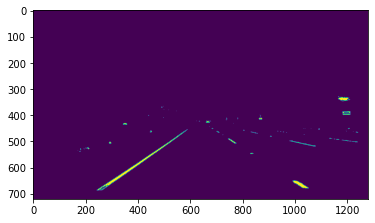

In [128]:
import matplotlib.pylab as plt
import cv2
import numpy as np

global first_frame
global filter_flag
global output
output = 'test.png'

global debug
debug = 0
first_frame = 1

def binary_threshold(img, low, high):
    output = np.zeros_like(img[:,:,0],  dtype=np.uint8)
    mask = (img[:,:,0] >= low[0]) & (img[:,:,0] <= high[0]) \
        & (img[:,:,1] >= low[1]) & (img[:,:,1] <= high[1]) \
        & (img[:,:,2] >= low[2]) & (img[:,:,2] <= high[2])
            
    output[mask] = 1
    return output

def get_binary_image(image):
    global first_frame
    global filter_flag
    
    ### HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L_max, L_mean = np.max(L), np.mean(L)
    print(L_mean, "l_mean")
    S = hls[:,:,2]
    S_max, S_mean = np.max(S), np.mean(S)

    #Changing filter cooficients based on the average lightning
    if (first_frame):
        if ((L_mean < 122) | (L_mean > 126)):
            filter_flag = 0
            print('p0')
        else:
            filter_flag = 1
            print('c0')
            
    
            
    if (not filter_flag):
        #yellow cooficients
        yellow_L_thr = 80
        ye_L_mean_coof = 1.25
        S_max_coof = 0.25
        S_mean_coof = 1.75
        #white cooficients
        white_L_thr = 160
        L_max_coof = 0.8
        wh_L_mean_coof = 1.25
        print('p1')
    else:
        #yellow cooficients
        yellow_L_thr = 0
        ye_L_mean_coof = 1
        S_max_coof = 0.1
        S_mean_coof = 1.7
        #white cooficients
        white_L_thr = 0
        L_max_coof = 0.7
        wh_L_mean_coof = 1.3
        print('c1')
        
        
    # YELLOW
    L_adapt_yellow = max(yellow_L_thr, int(L_mean * ye_L_mean_coof))
    S_adapt_yellow = max(int(S_max * S_max_coof), int(S_mean * S_mean_coof))
    S_adapt_yellow = S_adapt_yellow if (not filter_flag) else 25
    hls_low_yellow = np.array((15, L_adapt_yellow, S_adapt_yellow))
    hls_high_yellow = np.array((30, 255, 255))

    hls_yellow = binary_threshold(hls, hls_low_yellow, hls_high_yellow)

    # WHITE
    L_adapt_white =  max(white_L_thr, int(L_max *L_max_coof),int(L_mean * wh_L_mean_coof))
    hls_low_white = np.array((0, L_adapt_white,  0))
    hls_high_white = np.array((255, 255, 255))

    hls_white = binary_threshold(hls, hls_low_white, hls_high_white)

    
    hls_binary = hls_yellow | hls_white
    
    #show
#     plt.imshow(hls_binary)
    
    return  hls_binary 

image1 = cv2.imread('straight_lines1.jpg')
image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)  #BGR to RGB   
hls_binary = get_binary_image(image)
print(hls_binary.shape)
plt.imshow(hls_binary)

# PerspectiveTransform

Height: 720 , Width: 1280
(720, 1280)


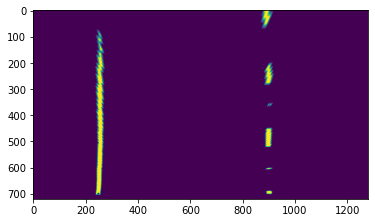

In [129]:
def perspectiveTrnsform(srcp ,dstp):
   M = cv2.getPerspectiveTransform(srcp ,dstp)
   Minv = cv2.getPerspectiveTransform(dstp ,srcp)
   return M ,Minv

def warpPerspective(img,imgsize,M):
    return cv2.warpPerspective(img,M,imgsize,cv2.INTER_LINEAR)

global src_first_pt, src_last_pt, dst_first_pt, dst_last_pt
def warp(image):
    global filter_flag
    global src_first_pt, src_last_pt, dst_first_pt, dst_last_pt

    if (not filter_flag):
        srcp = np.float32(
        [[685, 450],
          [1090, 710],
          [220, 710],
          [595, 450]])
        dstp = np.float32(
        [[900, 0],
          [900, 710],
          [250, 710],
          [250, 0]])
        
        src_first_pt = 220
        src_last_pt = 1090
        dst_first_pt = 250
        dst_last_pt = 900
    else:
        srcp = np.array([
            [200,713],
            [630,460],
            [750,460],
            [1200,713]
        ]).astype(np.float32)
        dstp = np.array([
            [300,713],
            [300,0],
            [1100,0],
            [1100,713]
        ]).astype(np.float32)
        
        print('c2')
        
        src_first_pt = 200
        src_last_pt = 1200
        dst_first_pt = 300
        dst_last_pt = 1100
    
    height = image.shape[0]
    width = image.shape[1]
    imgsize2 =(width,height)
    M,Minv = perspectiveTrnsform(srcp ,dstp)
    wraped_img = warpPerspective(image.astype(np.float32),imgsize2,M)
    print("Height:",height,", Width:",width)
    
    #show
#     plt.imshow(wraped_img)
    
    return wraped_img, Minv

wraped_img, Minv = warp(hls_binary)
print(wraped_img.shape)
plt.imshow(wraped_img)


# Histogram

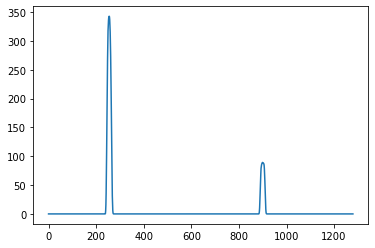

In [130]:
def get_histogram(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    #show
#     plt.plot(histogram)
#     plt.savefig('his.png')
    
    return histogram
    
histogram = get_histogram(wraped_img)
plt.plot(histogram)


# sliding window

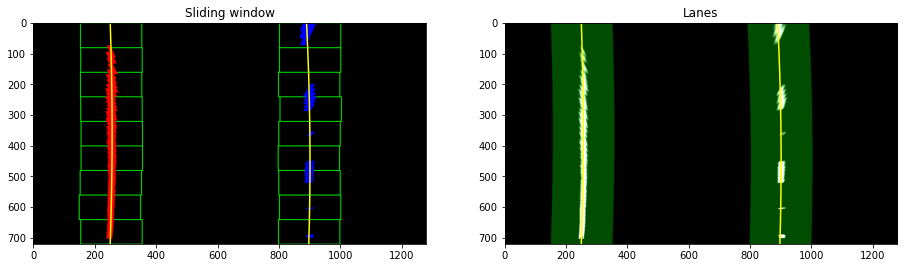

In [159]:
global test
test = 1
def slide_window(binary_warped, histogram):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.astype(np.uint8)
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_high = binary_warped.shape[0] - window*window_height
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    

    # Subplotting two plots 
    if (debug or output[len(output) - 3 :] != 'mp4') and test:
        f, (plt1, plt2) = plt.subplots(1, 2, figsize=(12, 4.5))
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

        ######################
        plt1.set_title("Sliding window")
        plt1.imshow(out_img)
        plt1.plot(left_fitx, ploty, color='yellow')
        plt1.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
     
    ################################ 
    ## Visualization
    ################################ 
    
    
    out_img2 = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img2 = out_img2.astype(np.uint8)
    window_img = np.zeros_like(out_img2)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img2, 1, window_img, 0.3, 0)
    
    if (debug or output[len(output) - 3 :] != 'mp4') and test:
        plt2.set_title("Lanes")
        plt2.imshow(result)
        plt2.plot(left_fitx, ploty, color='yellow')
        plt2.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig('lanes.jpg')
    
    
    
    #################
    
    ret = {}
    ret['leftx'] = leftx
    ret['rightx'] = rightx
    
    ret['left_fit'] = left_fit
    ret['right_fit'] = right_fit
    
    ret['left_fitx'] = left_fitx
    ret['right_fitx'] = right_fitx
    ret['ploty'] = ploty
    
    return ret, out_img, result
    

draw_info, out_img, lanes = slide_window(wraped_img, histogram)

# Lane Curvature

In [132]:
def measure_curvature(lines_info):
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700 

    ploty = lines_info['ploty']
    leftx = lines_info['left_fitx']
    rightx = lines_info['right_fitx']

    leftx = leftx[::-1]  
    rightx = rightx[::-1]  

    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    print("left_curverad:",left_curverad, 'm',", right_curverad:", right_curverad, 'm')
    
    return left_curverad, right_curverad
    
left_curverad, right_curverad = measure_curvature(draw_info)

left_curverad: 3346.8432416689384 m , right_curverad: 2962.540769676725 m


# Draw Lane Lines

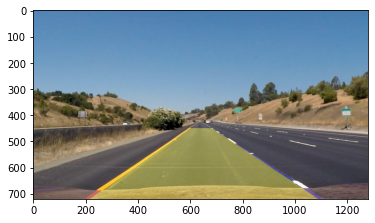

In [133]:
def draw_lane_lines(original_image, warped_image, Minv, draw_info):
    leftx = draw_info['leftx']
    rightx = draw_info['rightx']
    left_fitx = draw_info['left_fitx']
    right_fitx = draw_info['right_fitx']
    ploty = draw_info['ploty']
    
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # FIll the lane 
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (255,255, 0))
    
    # Draw left lane line
    pts_left_ = np.array([np.transpose(np.vstack([left_fitx -7, ploty]))])
    pts_left__ = np.array([np.flipud(np.transpose(np.vstack([left_fitx + 7, ploty])))])
    pts_l = np.hstack((pts_left_, pts_left__))
    cv2.fillPoly(color_warp, np.int_([pts_l]), (255,0, 0))

    # Draw right lane line
    pts_right_ = np.array([np.transpose(np.vstack([right_fitx -7, ploty]))])
    pts_right__ = np.array([np.flipud(np.transpose(np.vstack([right_fitx + 7, ploty])))])
    pts_r = np.hstack((pts_right_, pts_right__))
    cv2.fillPoly(color_warp, np.int_([pts_r]), (0,0, 255))
    
    # Take inverse prespective
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_image.shape[1], original_image.shape[0])) 
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    
    #show
#     plt.imshow(result)
    
    return result


result = draw_lane_lines(image, wraped_img, Minv, draw_info)
plt.imshow(result)

# Proccess Image

117.01900607638889 l_mean
p0
p1
Height: 720 , Width: 1280
left_curverad: 3346.8432416689384 m , right_curverad: 2962.540769676725 m
1086.3616904180967
219.94303034034044
640.0


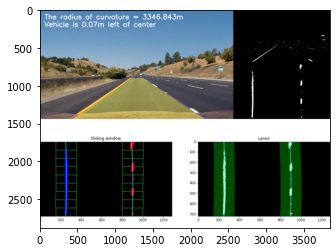

In [182]:
global used_warped
global used_draw_info
# global first_frame
global n_frames
first_frame = 1
n_frames = 0
output = 'test.png'

def single_pt_perspective(x, src_first_pt, src_last_pt, dst_first_pt, dst_last_pt):
#     new_x = (s_w/d_w)*(x-d_f) + s_f
    new_x = ((src_last_pt-src_first_pt)/(dst_last_pt-dst_first_pt)) * (x-dst_first_pt) + src_first_pt
    return new_x

def process_image(image):
    global used_warped
    global used_draw_info
    global filter_flag
    global output
    
#     if (filter_flag):
        
#         image = image1
#         print('k')

    # Generating HLS Binary Threshold
    hls_binary = get_binary_image(image)
#     plt.imshow(hls_binary)
    
    # Perspective Transform
    wraped_img, Minv = warp(hls_binary)
#     plt.imshow(wraped_img)
  
    # Getting Histogram
    histogram = get_histogram(wraped_img)
#     plt.savefig(histogram, format='png')
  
    # Sliding Window to detect lane lines
    try:
        draw_info, out_img, lanes = slide_window(wraped_img, histogram)
    except:
        draw_info = used_draw_info
        
    used_draw_info = draw_info
    
    left_fitx = draw_info['left_fitx']
    right_fitx = draw_info['right_fitx']
    ploty = draw_info['ploty']
    
#     plt.savefig(img_buf, format='png')
   
    # Measuring Curvature
    left_curverad, right_curverad = measure_curvature(draw_info)
   
    
    # Visualizing Lane Lines Info
    result = draw_lane_lines(image, wraped_img, Minv, draw_info)
#     plt.imshow(result)
  
    
    # Annotating curvature 
    fontType = cv2.FONT_HERSHEY_SIMPLEX
    curvature_text = 'The radius of curvature = ' + str(round(left_curverad, 3)) + 'm'
    cv2.putText(result, curvature_text, (30, 60), fontType, 1.5, (255, 255, 255), 3)
   
    # Annotating deviation
    global src_first_pt, src_last_pt, dst_first_pt, dst_last_pt
#     x = (s_w/d_w)*(y-d_f) + s_f
    right_fitx_inv = single_pt_perspective(draw_info['right_fitx'][-1], src_first_pt, src_last_pt, dst_first_pt, dst_last_pt)
    left_fitx_inv = single_pt_perspective(draw_info['left_fitx'][-1], src_first_pt, src_last_pt, dst_first_pt, dst_last_pt)
    
    deviation_pixels = image.shape[1]/2 - abs(right_fitx_inv/2 + left_fitx_inv/2)
    print(right_fitx_inv)
    print(left_fitx_inv)
    print(image.shape[1]/2)
    
#     xm_per_pix = 3.7/700 
    xm_per_pix = 6.77/1280 
    deviation = deviation_pixels * xm_per_pix
    direction = "left" if deviation < 0 else "right"
    deviation_text = 'Vehicle is ' + str(round(abs(deviation), 3)) + 'm ' + direction + ' of center'
    cv2.putText(result, deviation_text, (30, 110), fontType, 1.5, (255, 255, 255), 3)
    
    used_warped = wraped_img
    used_draw_info = draw_info
    
    #check first frame
    global first_frame
#     global n_frames
#     if n_frames <= 1 : first_frame = 1
#     else: first_frame = 0
#     n_frames +=1
    last_chars = output[len(output) - 3 :]
    if last_chars == 'mp4':
        first_frame = 0
    else: first_frame = 1
    
    
    global debug
    
#     debug = 1
    if debug == 1 or output[len(output) - 3 :] != 'mp4':
        
        resized = cv2.resize(result, (2560,1440))
#         resized = cv2.cvtColor(resized, cv2.COLOR_RGB2BGR)
        img1 = np.dstack((hls_binary, hls_binary, hls_binary))*255
        img1 = img1.astype(np.uint8)
        img2 = np.dstack((wraped_img, wraped_img, wraped_img))*255
        img2 = img2.astype(np.uint8)
        lanes = cv2.imread('lanes.jpg')
        lanes_ = cv2.resize(lanes, (3840,1440))
        
        v_img = np.vstack((img1, img2))
        h_img = np.hstack((resized, v_img))
        vv_img = np.vstack((h_img, lanes_))

#         cv2.imwrite(r'vvv.png',vv_img)
        result = vv_img
        
    
    
    return result 

image1 = cv2.imread('straight_lines1.jpg')
image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)  #BGR to RGB   
global test
test = ~ test
result_image = process_image(image)
plt.imshow(result_image)


# Create Output video

In [183]:
import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# def create_video(clip,output):   
global output
output = 'vj.mp4'
debug = 0
global first_frame
first_frame = 1
clip = VideoFileClip("challenge_video.mp4")
video_clip = clip.fl_image(process_image)
%time video_clip.write_videofile(output, audio=False, threads=4, codec="libx264")


t:   7%|█▉                         | 34/485 [21:11<08:45,  1.17s/it, now=None]


123.48694227430556 l_mean
c0
c1
c2
Height: 720 , Width: 1280
left_curverad: 471.86777212733097 m , right_curverad: 451.7908465892292 m
1140.278939347918
288.50751204678215
640.0
Moviepy - Building video vj.mp4.
Moviepy - Writing video vj.mp4



t:   0%|                                    | 0/485 [00:00<?, ?it/s, now=None]

123.48694227430556 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 471.86777212733097 m , right_curverad: 451.7908465892292 m
1140.278939347918
288.50751204678215
640.0



t:   0%|                            | 2/485 [00:00<01:17,  6.21it/s, now=None]

123.44559136284722 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 501.22673004503446 m , right_curverad: 519.0183961828129 m
1136.9915736027679
286.16179590714864
640.0



t:   1%|▏                           | 4/485 [00:00<02:04,  3.86it/s, now=None]

123.34963433159722 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 494.79979568697604 m , right_curverad: 553.241179439512 m
1133.0372351204974
285.7342499570949
640.0
123.25669270833333 l_mean
c1



t:   1%|▎                           | 5/485 [00:01<01:48,  4.42it/s, now=None]

c2
Height: 720 , Width: 1280
left_curverad: 617.2228405649334 m , right_curverad: 602.5100538312417 m
1133.0981025164815
281.96019762713786
640.0
123.23606770833334 l_mean
c1
c2
Height: 720 , Width: 1280



t:   1%|▎                           | 6/485 [00:01<01:42,  4.67it/s, now=None]

left_curverad: 510.7859510932543 m , right_curverad: 591.3689993127168 m
1130.6360687382564
285.70575057131117
640.0
123.17948133680555 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 614.4684449258115 m , right_curverad: 493.1688644204081 m



t:   2%|▍                           | 8/485 [00:01<01:33,  5.09it/s, now=None]

1134.5965838351403
282.8874753564227
640.0
123.19894965277778 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 768.6228618462469 m , right_curverad: 392.1484089002281 m
1154.5365094980255
281.36687226533076
640.0
123.15567599826389


t:   2%|▌                           | 9/485 [00:01<01:29,  5.30it/s, now=None]

 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 924.9718669106543 m , right_curverad: 433.8279671061402 m
1144.2831404745937
279.6936681373325
640.0
123.02165798611111 l_mean
c1



t:   2%|▌                          | 10/485 [00:02<01:28,  5.36it/s, now=None]

c2
Height: 720 , Width: 1280
left_curverad: 644.1000231772595 m , right_curverad: 399.8676078929378 m
1145.7897450753949
284.8963940984436
640.0
122.94802734375 l_mean
c1
c2
Height: 720 , Width: 1280



t:   2%|▌                          | 11/485 [00:02<01:24,  5.63it/s, now=None]

left_curverad: 594.4631978071819 m , right_curverad: 399.66891094034463 m
1144.8259120725018
287.5518990087988
640.0
122.90231336805556 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 607.8200936833991 m , right_curverad: 507.6148237195806 m
1133.1087989397224
286.68498259350594
640.0



t:   3%|▋                          | 13/485 [00:02<01:20,  5.88it/s, now=None]

122.94812934027777 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 687.9385067844416 m , right_curverad: 475.51639359578814 m
1138.3292932738136
286.3169791469934
640.0
122.92150282118055 l_mean
c1
c2



t:   3%|▊                          | 14/485 [00:02<01:18,  5.97it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 677.6073125704525 m , right_curverad: 492.96459488544315 m
1136.3243252192133
285.9412349563942
640.0
122.92768988715278 l_mean
c1
c2
Height: 720 , Width: 1280



t:   3%|▊                          | 15/485 [00:02<01:19,  5.89it/s, now=None]

left_curverad: 687.9081905294064 m , right_curverad: 562.6047205161191 m
1130.4182104200424
285.7473250469485
640.0
122.79551649305556 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 776.1366350593393 m , right_curverad: 538.58480792632 m



t:   4%|▉                          | 17/485 [00:03<01:21,  5.78it/s, now=None]

1130.7562739722953
284.0752568228759
640.0
122.63682942708333 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1646.692700420987 m , right_curverad: 414.15679434547036 m
1151.5819301434433
277.5847352300366
640.0
122.44393880208334


t:   4%|█                          | 18/485 [00:03<01:21,  5.74it/s, now=None]

 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1638.8655862738515 m , right_curverad: 446.2884361707594 m
1143.3568687491868
278.1632323282272
640.0
122.44165690104167 l_mean
c1



t:   4%|█                          | 19/485 [00:03<01:18,  5.90it/s, now=None]

c2
Height: 720 , Width: 1280
left_curverad: 5199.2236809132955 m , right_curverad: 516.8329058970958 m
1124.6552490552506
275.11994286587657
640.0
122.337958984375 l_mean
c1
c2
Height: 720 , Width: 1280



t:   4%|█                          | 20/485 [00:03<01:16,  6.08it/s, now=None]

left_curverad: 5493.762124085202 m , right_curverad: 530.3499572166887 m
1123.7489770326483
274.3148727737208
640.0
122.38035047743055 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 8268.47951046297 m , right_curverad: 546.9004381033116 m
1121.6278106941904
273.6334510336139
640.0



t:   5%|█▏                         | 22/485 [00:04<01:14,  6.22it/s, now=None]

122.28729058159722 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 3736.4853478541822 m , right_curverad: 481.3183451679587 m
1126.9232878699786
275.6366830936489
640.0
122.3674782986111 l_mean
c1
c2
Height: 720 , Width: 1280



t:   5%|█▎                         | 23/485 [00:04<01:12,  6.38it/s, now=None]

left_curverad: 3377.832143220435 m , right_curverad: 401.5237476854109 m
1132.2483081733203
276.49162361071603
640.0
122.30642252604167 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 19413.81865759977 m , right_curverad: 446.30641217862785 m
1127.9247943417681
270.6826249687447
640.0



t:   5%|█▍                         | 25/485 [00:04<01:10,  6.56it/s, now=None]

122.44438042534722 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 2770.0256852291145 m , right_curverad: 503.28566139637036 m
1117.2164238536384
269.8944635905787
640.0
122.43648871527778 l_mean
c1
c2
Height: 720 , Width: 1280



t:   6%|█▌                         | 27/485 [00:04<01:10,  6.48it/s, now=None]

left_curverad: 1788.6675646210142 m , right_curverad: 441.80941545053366 m
1118.4427755878014
270.4644788933613
640.0
122.51132486979166 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1284.5936445610475 m , right_curverad: 432.28357998483926 m
1112.8004765181834
271.6411261135718
640.0
122.36294379340278 l_mean



t:   6%|█▌                         | 28/485 [00:04<01:13,  6.18it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 2186.6783462173144 m , right_curverad: 260.84187990148155 m
1128.0176912168663
278.2961647989025
640.0
122.3401833767361 l_mean
c1
c2



t:   6%|█▌                         | 29/485 [00:05<01:13,  6.23it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 36857.98888917477 m , right_curverad: 265.3232185192292 m
1117.6634066080762
276.66582121877013
640.0
122.35163302951389 l_mean
c1
c2
Height: 720 , Width: 1280



t:   6%|█▋                         | 30/485 [00:05<01:14,  6.14it/s, now=None]

left_curverad: 1242.1193068127473 m , right_curverad: 266.49829492041164 m
1113.3358807429852
281.4763691475648
640.0
122.37231662326388 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1120.2301566499516 m , right_curverad: 254.4041216847896 m
1109.653718302866
279.5931076433024
640.0



t:   7%|█▊                         | 32/485 [00:05<01:14,  6.05it/s, now=None]

122.15467230902777 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 448.4945893876237 m , right_curverad: 282.70849780214695 m
1098.2934552293743
291.914851575477
640.0
122.35345594618056 l_mean
c1
c2



t:   7%|█▊                         | 33/485 [00:05<01:12,  6.23it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 451.56663531404047 m , right_curverad: 287.74549209594244 m
1094.9571860729575
289.8695961033866
640.0
122.33466471354167 l_mean
c1
c2
Height: 720 , Width: 1280



t:   7%|█▉                         | 34/485 [00:06<01:20,  5.57it/s, now=None]

left_curverad: 388.44453246052353 m , right_curverad: 292.4916268301956 m
1093.1870118986494
292.8822276560736
640.0
122.2358224826389 l_mean
c1
c2
Height: 720 , Width: 1280



t:   7%|█▉                         | 35/485 [00:06<01:32,  4.88it/s, now=None]

left_curverad: 368.82509115739475 m , right_curverad: 283.49955861486126 m
1091.3311483754749
292.3688735793395
640.0
122.23777777777778 l_mean
c1
c2
Height: 720 , Width: 1280



t:   7%|██                         | 36/485 [00:06<01:33,  4.80it/s, now=None]

left_curverad: 322.40336295523616 m , right_curverad: 253.69516223561743 m
1099.2725900138623
294.39096430034465
640.0
122.327666015625 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 397.26348065611035 m , right_curverad: 188.32899349441774 m



t:   8%|██                         | 37/485 [00:06<01:30,  4.93it/s, now=None]

1125.8246921948523
289.18875515131026
640.0
122.41413194444445 l_mean
c1
c2
Height: 720 , Width: 1280



t:   8%|██                         | 38/485 [00:06<01:35,  4.69it/s, now=None]

left_curverad: 437.1520135534177 m , right_curverad: 181.94923415628708 m
1118.887235516468
287.61421153891206
640.0
122.44203125 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 361.01210358243895 m , right_curverad: 190.04365874629696 m
1104.8696061160547
288.70507680273704
640.0



t:   8%|██▏                        | 40/485 [00:07<01:26,  5.15it/s, now=None]

122.48712673611111 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 349.65957703190577 m , right_curverad: 169.25938761140847 m
1112.3657165453335
288.1415197827199
640.0
122.52444769965278 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 291.11260416853935 m , right_curverad: 166.01430303112332 m
1106.7785579733913
289.8820561441306
640.0



t:   8%|██▎                        | 41/485 [00:07<01:30,  4.91it/s, now=None]

122.42443359375 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 304.417543384333 m , right_curverad: 176.0668508005219 m
1099.2335989101916
285.5275988646706
640.0



t:   9%|██▍                        | 43/485 [00:07<01:28,  4.99it/s, now=None]

122.55713216145833 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 362.1861878740163 m , right_curverad: 175.20878239119867 m
1091.1744201843617
280.96129273992034
640.0
122.71056315104167 l_mean


c1
c2
Height: 720 , Width: 1280
left_curverad: 284.1725572212903 m , right_curverad: 174.659885622495 m
1082.1925453459885
283.47988108037543
640.0


t:   9%|██▌                        | 45/485 [00:08<01:23,  5.27it/s, now=None]

122.78208767361112 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 240.7969808066107 m , right_curverad: 178.5960859474185 m
1072.7529534232103
283.27829045445384
640.0
122.91728515625 l_mean
c1
c2



t:   9%|██▌                        | 46/485 [00:08<01:22,  5.34it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 248.89221555787876 m , right_curverad: 182.74808533698405 m
1056.1464672958894
280.29373505210935
640.0
122.81801323784723 l_mean
c1
c2
Height: 720 , Width: 1280



t:  10%|██▌                        | 47/485 [00:08<01:25,  5.14it/s, now=None]

left_curverad: 291.0453996035217 m , right_curverad: 192.05658526002432 m
1054.8245224989591
273.03729569423865
640.0
122.57915798611111 l_mean
c1
c2
Height: 720 , Width: 1280



t:  10%|██▋                        | 48/485 [00:09<01:46,  4.12it/s, now=None]

left_curverad: 323.17240176971126 m , right_curverad: 189.23648808957006 m
1053.8732831662717
267.28249765284795
640.0
122.35627061631945 l_mean
c1



t:  10%|██▋                        | 49/485 [00:09<01:46,  4.08it/s, now=None]

c2
Height: 720 , Width: 1280
left_curverad: 287.1726283065381 m , right_curverad: 193.48312568095656 m
1051.627531414652
266.9254927779457
640.0
122.23186414930555 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 269.88227039689895 m , right_curverad: 179.34134893296329 m



t:  10%|██▊                        | 50/485 [00:09<01:49,  3.96it/s, now=None]

1050.4330012893954
266.6155511978375
640.0
122.0278146701389 l_mean
c1
c2
Height: 720 , Width: 1280



t:  11%|██▊                        | 51/485 [00:09<01:46,  4.07it/s, now=None]

left_curverad: 275.9608294105367 m , right_curverad: 172.52893550713725 m
1053.235546282826
263.77628434047773
640.0
121.81630642361111 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 282.41894658547164 m , right_curverad: 167.70843673539002 m



t:  11%|██▉                        | 52/485 [00:09<01:38,  4.40it/s, now=None]

1049.1091151748005
260.66836794641296
640.0
121.54704535590278 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 276.16442429713567 m , right_curverad: 169.2308763945003 m
1042.5623526906813
259.6872573979647
640.0



t:  11%|██▉                        | 53/485 [00:10<01:32,  4.67it/s, now=None]

121.44173936631944 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 278.2562757363126 m , right_curverad: 153.93166770288477 m
1045.364017087944
258.54903286282166
640.0



t:  11%|███                        | 54/485 [00:10<01:31,  4.69it/s, now=None]

121.31219292534722 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 274.8377359345249 m , right_curverad: 161.26422368497035 m
1045.0616124584485
255.66124012937445
640.0



t:  11%|███                        | 55/485 [00:10<01:31,  4.69it/s, now=None]

121.14122178819444 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 364.4372217107858 m , right_curverad: 164.2178324938811 m
1038.6361140306583


t:  12%|███                        | 56/485 [00:10<01:32,  4.65it/s, now=None]


249.6376539422451
640.0
120.899072265625 l_mean
c1
c2
Height: 720 , Width: 1280


t:  12%|███▏                       | 57/485 [00:11<01:50,  3.89it/s, now=None]


left_curverad: 329.56716381370154 m , right_curverad: 165.59771644160008 m
1033.1030851230155
249.85512514736925
640.0
120.65167317708334 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 270.55060063550854 m , right_curverad: 163.81530919451677 m



t:  12%|███▏                       | 58/485 [00:11<01:48,  3.94it/s, now=None]

1027.4417865151054
253.70247226096822
640.0
120.31541883680555 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 266.5236414289344 m , right_curverad: 165.3598713614103 m
1021.5565670248567
252.71454551531428
640.0



t:  12%|███▎                       | 59/485 [00:11<01:38,  4.33it/s, now=None]


120.2124490017361 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 264.78218468653284 m , right_curverad: 171.21224366848185 m
1015.9924626920587
254.43183143942136
640.0


t:  12%|███▎                       | 60/485 [00:11<01:33,  4.57it/s, now=None]

120.13388563368055 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 310.16317110011 m , right_curverad: 173.86850426401205 m
1014.0898687919068
248.22542852671603
640.0



t:  13%|███▍                       | 61/485 [00:11<01:36,  4.41it/s, now=None]

119.84743598090277 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 281.0957986407891 m , right_curverad: 182.25869547935332 m
1011.7055699079315
249.88003375155932
640.0



t:  13%|███▍                       | 62/485 [00:12<01:33,  4.51it/s, now=None]

119.67466688368056 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 318.6017993835481 m , right_curverad: 190.72493521128345 m
1011.9747105868414
245.09278522104103
640.0



t:  13%|███▌                       | 64/485 [00:12<01:28,  4.76it/s, now=None]

119.57505750868056 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 320.0277170047122 m , right_curverad: 183.4596676419674 m
1015.5420055417515
246.13754150147395
640.0
119.35104709201389 l_mean



t:  13%|███▌                       | 65/485 [00:12<01:24,  4.96it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 299.97322390384363 m , right_curverad: 167.26111605835237 m
1027.0058253480427
245.35371944453237
640.0
119.24306315104167 l_mean
c1



t:  14%|███▋                       | 66/485 [00:12<01:21,  5.16it/s, now=None]

c2
Height: 720 , Width: 1280
left_curverad: 370.06768210251687 m , right_curverad: 168.85965405621005 m
1023.2590202843198
241.59892848038098
640.0
119.05604600694444 l_mean
c1
c2



t:  14%|███▋                       | 67/485 [00:13<01:32,  4.53it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 457.655461346324 m , right_curverad: 166.13602072521905 m
1020.7563052792965
240.82479722434078
640.0
119.28405164930555 l_mean



t:  14%|███▊                       | 68/485 [00:13<01:28,  4.72it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 425.2495701830099 m , right_curverad: 164.8446281542796 m
1017.651675458362
244.08503686087286
640.0
118.80568467881945 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 461.7092620264291 m , right_curverad: 167.74796482646275 m



t:  14%|███▊                       | 69/485 [00:13<01:35,  4.35it/s, now=None]

1014.4357768327
245.85908094615647
640.0
118.93736436631944 l_mean
c1
c2
Height: 720 , Width: 1280



t:  14%|███▉                       | 70/485 [00:14<01:47,  3.87it/s, now=None]

left_curverad: 384.6109738262302 m , right_curverad: 154.99119953836924 m
1018.480501239748
251.91127028484993
640.0
118.78466688368056 l_mean
c1
c2
Height: 720 , Width: 1280



t:  15%|███▉                       | 71/485 [00:14<01:42,  4.03it/s, now=None]

left_curverad: 406.0368219180189 m , right_curverad: 163.81382105176576 m
1014.8305380686394
252.0259984355286
640.0
119.07029730902778 l_mean
c1
c2
Height: 720 , Width: 1280



t:  15%|████                       | 72/485 [00:14<01:38,  4.18it/s, now=None]

left_curverad: 437.83502388418515 m , right_curverad: 177.84431506223476 m
1010.3910491425099
253.96130835997653
640.0
119.30999348958333 l_mean
c1
c2
Height: 720 , Width: 1280



t:  15%|████                       | 73/485 [00:14<01:37,  4.22it/s, now=None]

left_curverad: 415.4411910169482 m , right_curverad: 201.91600911259926 m
1006.6316484694848
255.19556006443082
640.0
119.49961588541667 l_mean
c1
c2
Height: 720 , Width: 1280



t:  15%|████                       | 74/485 [00:14<01:36,  4.24it/s, now=None]

left_curverad: 408.5506862529118 m , right_curverad: 204.99739718889302 m
1006.0779477690005
255.36180520958553
640.0
119.37369683159723 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 502.55757599105857 m , right_curverad: 218.62627629126197 m



t:  15%|████▏                      | 75/485 [00:15<01:31,  4.48it/s, now=None]

1005.6196601383524
254.91790249636196
640.0
119.75591037326389 l_mean
c1
c2
Height: 720 , Width: 1280



t:  16%|████▏                      | 76/485 [00:15<01:46,  3.86it/s, now=None]

left_curverad: 561.4982192711013 m , right_curverad: 216.32440723278805 m
1006.6247112649958
257.5829474359888
640.0
119.73714192708333 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1298.088927001483 m , right_curverad: 223.58080265432858 m



t:  16%|████▎                      | 77/485 [00:15<01:38,  4.15it/s, now=None]

1004.7198187144626
253.09836964555353
640.0
119.71219292534722 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 786.9884738518953 m , right_curverad: 235.2257610145274 m



t:  16%|████▎                      | 78/485 [00:15<01:35,  4.27it/s, now=None]

1000.3421487197362
256.99400204866197
640.0
119.56690863715278 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 342.03638059340693 m , right_curverad: 282.5897634791484 m



t:  16%|████▍                      | 79/485 [00:16<01:33,  4.33it/s, now=None]

983.4266510415101
264.3080811753339
640.0
119.69740668402778 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad:


t:  16%|████▍                      | 80/485 [00:16<01:31,  4.44it/s, now=None]

 310.06612130747953 m , right_curverad: 268.7465708552472 m
988.0953765929214
267.42782411193963
640.0
119.71280381944445 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 280.40014123416233 m , right_curverad: 267.2288161894846 m



t:  17%|████▌                      | 81/485 [00:16<01:28,  4.57it/s, now=None]

990.6544327582118
267.8601006345042
640.0
119.68177300347222 l_mean
c1
c2
Height: 720 , Width: 1280



t:  17%|████▌                      | 82/485 [00:16<01:33,  4.32it/s, now=None]

left_curverad: 269.0525977202734 m , right_curverad: 258.2018540555957 m
994.2486294531632
270.67574681399896
640.0
119.35282443576389 l_mean
c1
c2
Height: 720 , Width: 1280



t:  17%|████▌                      | 83/485 [00:17<01:34,  4.24it/s, now=None]

left_curverad: 381.9235310632385 m , right_curverad: 278.1475776965493 m
999.4834804470595
261.2789987167988
640.0
119.25002387152777 l_mean
c1
c2
Height: 720 , Width: 1280



t:  17%|████▋                      | 84/485 [00:17<01:35,  4.18it/s, now=None]

left_curverad: 458.92755068902017 m , right_curverad: 294.96269591360914 m
1001.0247605783534
255.3643978960843
640.0
119.026259765625 l_mean
c1
c2
Height: 720 , Width: 1280



t:  18%|████▋                      | 85/485 [00:17<01:40,  4.00it/s, now=None]

left_curverad: 391.23549992206966 m , right_curverad: 293.68810486000416 m
1003.8186000150438
259.58698038737896
640.0
119.07211805555555 l_mean
c1
c2
Height: 720 , Width: 1280



t:  18%|████▊                      | 86/485 [00:17<01:40,  3.99it/s, now=None]

left_curverad: 389.9085925851015 m , right_curverad: 308.1082718999231 m
1004.4937518868655
258.3958931877828
640.0
118.99278211805556 l_mean
c1
c2
Height: 720 , Width: 1280



t:  18%|████▊                      | 87/485 [00:18<01:39,  3.99it/s, now=None]

left_curverad: 379.11151478245245 m , right_curverad: 317.1270911890132 m
1006.9094276089106
259.90380828767536
640.0
119.10564670138889 l_mean
c1
c2
Height: 720 , Width: 1280



t:  18%|████▉                      | 88/485 [00:18<01:39,  4.00it/s, now=None]

left_curverad: 340.88768824598213 m , right_curverad: 304.7773699649698 m
1008.429952848028
265.1233811355753
640.0
119.12344075520834 l_mean
c1
c2
Height: 720 , Width: 1280



t:  18%|████▉                      | 89/485 [00:18<01:42,  3.85it/s, now=None]

left_curverad: 416.0926481180326 m , right_curverad: 288.3815774908044 m
1011.727645926371
259.927178970815
640.0
119.23199544270834 l_mean
c1
c2
Height: 720 , Width: 1280



t:  19%|█████                      | 90/485 [00:18<01:38,  4.02it/s, now=None]

left_curverad: 540.8824909587746 m , right_curverad: 282.4962965155418 m
1014.6633996021973
253.24308729490255
640.0
118.889248046875 l_mean
c1
c2
Height: 720 , Width: 1280



t:  19%|█████                      | 91/485 [00:19<01:39,  3.96it/s, now=None]

left_curverad: 626.7537573010953 m , right_curverad: 295.36427822280444 m
1017.7668644607702
252.5763742435728
640.0
118.6552615017361 l_mean
c1
c2
Height: 720 , Width: 1280



t:  19%|█████                      | 92/485 [00:19<01:39,  3.96it/s, now=None]

left_curverad: 787.100306492601 m , right_curverad: 300.8750227217454 m
1019.3075407383081
253.01165622767934
640.0
118.37720703125 l_mean
c1
c2
Height: 720 , Width: 1280



t:  19%|█████▏                     | 93/485 [00:19<01:36,  4.05it/s, now=None]

left_curverad: 648.4432657230774 m , right_curverad: 318.6504148139674 m
1016.7936413308887
256.93101621393794
640.0
118.13889214409723 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 689.46491934717 m , right_curverad: 307.89434361794224 m



t:  19%|█████▏                     | 94/485 [00:19<01:29,  4.37it/s, now=None]

1023.0556128121002
258.1502121830699
640.0
117.9107400173611 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 753.5265698999964 m , right_curverad: 317.77493489605047 m
1026.8632158796706
260.51329406540447
640.0



t:  20%|█████▎                     | 95/485 [00:19<01:24,  4.60it/s, now=None]

118.02642469618056 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 839.7301038818574 m , right_curverad: 302.4057939561611 m
1028.1826927529867
263.176490544755
640.0



t:  20%|█████▎                     | 96/485 [00:20<01:23,  4.64it/s, now=None]

117.6581640625 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1148.5825151770464 m , right_curverad: 292.18028333270723 m
1029.7954134389067
265.86128757561227
640.0



t:  20%|█████▍                     | 98/485 [00:20<01:20,  4.83it/s, now=None]

117.6294921875 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1563.137624609705 m , right_curverad: 267.7438314628933 m
1029.3617655912608
273.6105112513194
640.0
117.17400716145833 l_mean
c1
c2
Height: 720 , Width: 1280



t:  20%|█████▌                     | 99/485 [00:20<01:27,  4.41it/s, now=None]

left_curverad: 1543.8846926383521 m , right_curverad: 256.2106293858385 m
1030.9479881001423
279.165696257717
640.0
116.871435546875 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1474.489471462939 m , right_curverad: 243.73911467865605 m



t:  21%|█████▍                    | 101/485 [00:21<01:16,  5.05it/s, now=None]

1030.6175328471952
284.87515247301843
640.0
116.31089301215277 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1018.1367438937597 m , right_curverad: 255.61672891090058 m
1031.9829295213135
290.9675177922786
640.0
115.79656141493055 l_mean



t:  21%|█████▍                    | 102/485 [00:21<01:14,  5.11it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 1159.636235402152 m , right_curverad: 275.7067962453819 m
1034.0685257255354
290.5350198042869
640.0
115.05596462673611 l_mean



t:  21%|█████▌                    | 103/485 [00:21<01:10,  5.39it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 1660.0563897192671 m , right_curverad: 298.09471262105745 m
1036.113545727982
290.3742733119482
640.0
114.47512369791667 l_mean
c1
c2



t:  21%|█████▌                    | 104/485 [00:21<01:09,  5.51it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 2310.2846645343625 m , right_curverad: 306.7525963155625 m
1037.9367946089606
290.0221067820838
640.0
113.44093424479166 l_mean
c1
c2
Height: 720 , Width: 1280



t:  22%|█████▋                    | 105/485 [00:21<01:08,  5.54it/s, now=None]

left_curverad: 2364.1074238197175 m , right_curverad: 326.83090263115724 m
1040.2303627399283
289.5717377315569
640.0
112.94607964409722 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1900.3477464228592 m , right_curverad: 311.7518073562803 m



t:  22%|█████▋                    | 107/485 [00:22<01:05,  5.78it/s, now=None]

1044.1475840670275
291.52906574944143
640.0
111.82955403645833 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 9679.057212594298 m , right_curverad: 338.27245592860163 m
1041.6420694118597
285.99164204997777
640.0
111.07270290798611 l_mean



t:  22%|█████▊                    | 108/485 [00:22<01:02,  6.00it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 9557.454895787547 m , right_curverad: 327.8732999843711 m
1044.661592741278
286.2620186062216
640.0
110.17493706597222 l_mean
c1
c2



t:  22%|█████▊                    | 109/485 [00:22<01:06,  5.62it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 7009.72833099648 m , right_curverad: 308.4536263116692 m
1044.627109250073
286.79208201164886
640.0
108.94729926215278 l_mean
c1
c2
Height: 720 , Width: 1280



t:  23%|█████▉                    | 111/485 [00:22<01:04,  5.78it/s, now=None]

left_curverad: 1640.5788948410018 m , right_curverad: 301.70616413173235 m
1041.955933056181
291.3305198389043
640.0
107.8279709201389 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 2619.960547584298 m , right_curverad: 338.24944845058013 m
1037.7099074159223
292.0719470587978
640.0
105.93660373263889 l_mean



t:  23%|██████                    | 112/485 [00:23<01:05,  5.72it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 5400.9865860593345 m , right_curverad: 316.9569742592038 m
1039.6902088884747
293.0602929008792
640.0
104.14314236111112 l_mean
c1



t:  23%|██████                    | 113/485 [00:23<01:05,  5.64it/s, now=None]

c2
Height: 720 , Width: 1280
left_curverad: 29799.518827372503 m , right_curverad: 290.03775291002785 m
1044.0477656844726
294.7735360179431
640.0
102.23279188368056 l_mean
c1
c2
Height: 720 , Width: 1280



t:  24%|██████                    | 114/485 [00:23<01:04,  5.71it/s, now=None]

left_curverad: 2398.827143995587 m , right_curverad: 305.73875713108333 m
1041.4114208636124
293.71792326878153
640.0
100.20381727430555 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 2549.1356165620864 m , right_curverad: 337.9801907682682 m
1043.8703129784622
293.6261500181777
640.0



t:  24%|██████▏                   | 116/485 [00:23<01:04,  5.75it/s, now=None]

98.16538845486112 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1856.4174405986287 m , right_curverad: 579.4513276238889 m
1039.1455561936712
294.5608709879682
640.0
95.25089518229167 l_mean
c1
c2



t:  24%|██████▎                   | 117/485 [00:23<01:03,  5.81it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 1160.4175825195966 m , right_curverad: 369.07988722477774 m
1048.9847074564827
294.5560050770805
640.0
92.16069010416666 l_mean
c1
c2
Height: 720 , Width: 1280



t:  24%|██████▎                   | 118/485 [00:24<01:02,  5.92it/s, now=None]

left_curverad: 1619.5996219108833 m , right_curverad: 333.1682092963068 m
1048.7089419287486
296.62993297648904
640.0
89.95230577256945 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 2869.62327253671 m , right_curverad: 451.819956507328 m
1049.4558348824278


t:  25%|██████▍                   | 120/485 [00:24<00:57,  6.32it/s, now=None]


300.83776948004333
640.0
88.1877267795139 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 591.9618575917567 m , right_curverad: 393.5858009501413 m
1050.75595700754
306.098079208748
640.0
86.28839192708334 l_mean
c1
c2



t:  25%|██████▍                   | 121/485 [00:24<01:01,  5.89it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 1110.6503140207774 m , right_curverad: 392.4360735486448 m
1046.8642283145462
297.40080718235225
640.0
82.09860134548612 l_mean
c1
c2
Height: 720 , Width: 1280



t:  25%|██████▌                   | 122/485 [00:24<01:01,  5.91it/s, now=None]

left_curverad: 749.6038963788799 m , right_curverad: 364.71552224659206 m
1048.7399581868806
298.2728843207067
640.0
78.12373155381944 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 501.3210962006083 m , right_curverad: 357.4831215099082 m
1050.7748329387164
302.41360373400676
640.0



t:  26%|██████▋                   | 124/485 [00:25<00:58,  6.18it/s, now=None]

74.71533420138888 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 230.76616454146176 m , right_curverad: 363.9092334781843 m
1049.2924355826863
304.8096932443002
640.0
71.799697265625 l_mean
c1
c2
Height: 720 


t:  26%|██████▋                   | 125/485 [00:25<00:58,  6.19it/s, now=None]

, Width: 1280
left_curverad: 244.15931659404234 m , right_curverad: 340.95556691891414 m
1052.8400834697131
304.0655262334128
640.0
69.69267252604166 l_mean
c1
c2
Height: 720 , Width: 1280



t:  26%|██████▊                   | 127/485 [00:25<00:57,  6.27it/s, now=None]

left_curverad: 182.14595746597283 m , right_curverad: 363.8579543093727 m
1047.2134854693873
304.4569764490015
640.0
68.4493088107639 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 451.65647752684987 m , right_curverad: 382.2925387814421 m
1048.0777294472139
302.07225611791876
640.0
67.16474283854167 l_mean



t:  26%|██████▊                   | 128/485 [00:25<00:56,  6.33it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 1544.1986102890287 m , right_curverad: 426.37104669367625 m
1044.1783231171758
301.4012962511611
640.0
66.29261610243056 l_mean
c1
c2



t:  27%|██████▉                   | 129/485 [00:25<00:57,  6.20it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 419.1673196644541 m , right_curverad: 372.91881160202735 m
1049.5219630815625
300.93096866472706
640.0
64.050126953125 l_mean
c1
c2
Height: 720 , Width: 1280



t:  27%|███████                   | 131/485 [00:26<00:55,  6.33it/s, now=None]

left_curverad: 100.8613332293663 m , right_curverad: 401.2823722694792 m
1049.7857367418032
303.95385921050433
640.0
55.827109375 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 92.84259805687485 m , right_curverad: 416.42939163109236 m
1050.0829805928906
320.31004649002284
640.0
53.13564453125 


t:  27%|███████                   | 132/485 [00:26<00:54,  6.44it/s, now=None]

l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1419.1106267554267 m , right_curverad: 384.03256282675414 m
1050.8556477533602
287.6486205506848
640.0
50.83039279513889 l_mean
c1
c2
Height: 720 , Width: 1280



t:  27%|███████▏                  | 133/485 [00:26<00:55,  6.37it/s, now=None]

left_curverad: 301.7741788675774 m , right_curverad: 374.59181064921563 m
1050.8120599676076
275.95979940771593
640.0
48.90059027777778 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1052.8559883417959 m , right_curverad: 356.17828759444404 m
1049.711875900724
299.76296855597724
640.0



t:  28%|███████▏                  | 135/485 [00:26<00:52,  6.72it/s, now=None]

50.32832899305556 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1052.8559883417959 m , right_curverad: 356.17828759444404 m
1049.711875900724
299.76296855597724
640.0
53.63274956597222 l_mean
c1
c2
Height: 720 , Width: 1280



t:  28%|███████▎                  | 136/485 [00:26<00:53,  6.48it/s, now=None]

left_curverad: 1052.8559883417959 m , right_curverad: 356.17828759444404 m
1049.711875900724
299.76296855597724
640.0
58.54664496527778 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1052.8559883417959 m , right_curverad: 356.17828759444404 m



t:  28%|███████▎                  | 137/485 [00:27<00:57,  6.10it/s, now=None]


1049.711875900724
299.76296855597724
640.0
62.727787543402776 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1052.8559883417959 m , right_curverad: 356.17828759444404 m
1049.711875900724
299.76296855597724
640.0


t:  29%|███████▍                  | 139/485 [00:27<00:55,  6.23it/s, now=None]

68.69685655381944 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1052.8559883417959 m , right_curverad: 356.17828759444404 m
1049.711875900724
299.76296855597724
640.0
75.54789605034722 l_mean
c1
c2
Height: 720 , Width: 1280



t:  29%|███████▌                  | 140/485 [00:27<01:04,  5.36it/s, now=None]

left_curverad: 905.622275656026 m , right_curverad: 1995.6835086286826 m
990.4934353331367
207.4251473358296
640.0
83.57845703125 l_mean
c1
c2
Height: 720 , Width: 1280



t:  29%|███████▌                  | 141/485 [00:27<01:09,  4.94it/s, now=None]

left_curverad: 269.3294823247886 m , right_curverad: 10568.581029932257 m
980.299752574689
90.87316994546747
640.0
93.40561089409722 l_mean
c1
c2
Height: 720 , Width: 1280



t:  29%|███████▌                  | 142/485 [00:28<01:31,  3.75it/s, now=None]

left_curverad: 247.7415350034536 m , right_curverad: 11956.469323721241 m
966.9161251367038
107.01281851924449
640.0
103.98721245659722 l_mean
c1
c2
Height: 720 , Width: 1280



t:  29%|███████▋                  | 143/485 [00:28<01:37,  3.52it/s, now=None]

left_curverad: 1496.2549458510878 m , right_curverad: 10706.683120993715 m
959.8086579397236
331.8899866384188
640.0
111.08408528645833 l_mean
c1
c2
Height: 720 , Width: 1280



t:  30%|███████▋                  | 144/485 [00:29<01:46,  3.19it/s, now=None]

left_curverad: 380.64720467799094 m , right_curverad: 50038.88487804933 m
953.0258804600311
408.07735896846964
640.0
114.958759765625 l_mean
c1
c2
Height: 720 , Width: 1280



t:  30%|███████▊                  | 145/485 [00:29<01:46,  3.20it/s, now=None]

left_curverad: 479.40652780558446 m , right_curverad: 55909.985621794614 m
964.0932180318275
384.3487447991773
640.0
117.34731119791667 l_mean
c1
c2
Height: 720 , Width: 1280



t:  30%|███████▊                  | 146/485 [00:29<01:41,  3.35it/s, now=None]

left_curverad: 391.0112481219853 m , right_curverad: 86050.24671805596 m
969.0878624932063
399.6468899679428
640.0
118.69953559027778 l_mean
c1
c2
Height: 720 , Width: 1280



t:  30%|███████▉                  | 147/485 [00:29<01:39,  3.41it/s, now=None]

left_curverad: 448.2604120020682 m , right_curverad: 104837.66784661952 m
979.1604533368803
385.39479654401816
640.0
123.63878038194444 l_mean
c1
c2
Height: 720 , Width: 1280



t:  31%|███████▉                  | 148/485 [00:30<01:44,  3.21it/s, now=None]

left_curverad: 469.09192050333974 m , right_curverad: 26098.747938064917 m
937.9316712388345
374.1466018014018
640.0
128.84171549479166 l_mean
c1
c2
Height: 720 , Width: 1280



t:  31%|███████▉                  | 149/485 [00:30<01:43,  3.24it/s, now=None]

left_curverad: 392.00840875982647 m , right_curverad: 20802.685368444592 m
980.8916579995118
381.6591284685977
640.0
130.96258572048612 l_mean
c1
c2
Height: 720 , Width: 1280



t:  31%|████████                  | 150/485 [00:30<01:46,  3.16it/s, now=None]

left_curverad: 320.5978837731679 m , right_curverad: 27447.017964770206 m
983.89584851182
396.08952706941545
640.0
131.35454210069443 l_mean
c1
c2
Height: 720 , Width: 1280



t:  31%|████████                  | 151/485 [00:31<01:43,  3.24it/s, now=None]

left_curverad: 294.94766899095686 m , right_curverad: 116775.6352862994 m
1001.3995443682661
390.7073734049948
640.0
133.2183713107639 l_mean
c1
c2
Height: 720 , Width: 1280



t:  31%|████████▏                 | 152/485 [00:31<01:36,  3.45it/s, now=None]

left_curverad: 421.7286924696424 m , right_curverad: 34533.704288811314 m
990.1096247589077
350.06031057976486
640.0
134.97109592013888 l_mean
c1
c2
Height: 720 , Width: 1280



t:  32%|████████▏                 | 153/485 [00:31<01:40,  3.31it/s, now=None]

left_curverad: 476.79007455095996 m , right_curverad: 51280.88120086624 m
993.0753632995003
338.647000897828
640.0
137.1375043402778 l_mean
c1
c2
Height: 720 , Width: 1280



t:  32%|████████▎                 | 154/485 [00:32<01:47,  3.07it/s, now=None]

left_curverad: 456.10087048528544 m , right_curverad: 80636.23936471152 m
995.2648791728818
336.80698178782654
640.0
138.5029177517361 l_mean
c1
c2
Height: 720 , Width: 1280



t:  32%|████████▎                 | 155/485 [00:32<01:48,  3.03it/s, now=None]

left_curverad: 610.6582695509051 m , right_curverad: 48462.794040261666 m
999.0309424384548
321.42039553569987
640.0
140.26872938368055 l_mean
c1
c2
Height: 720 , Width: 1280



t:  32%|████████▎                 | 156/485 [00:32<01:49,  3.01it/s, now=None]

left_curverad: 438.1058557913836 m , right_curverad: 445279.0083305701 m
1006.0684697247898
331.61072735632473
640.0
142.42810329861112 l_mean
c1
c2
Height: 720 , Width: 1280



t:  32%|████████▍                 | 157/485 [00:33<01:48,  3.03it/s, now=None]

left_curverad: 655.6100069541152 m , right_curverad: 8410.058990025367 m
1015.6809105485684
316.2138188257168
640.0
144.59724283854166 l_mean
c1
c2
Height: 720 , Width: 1280



t:  33%|████████▍                 | 158/485 [00:33<01:46,  3.08it/s, now=None]

left_curverad: 396.4404467395653 m , right_curverad: 678.8508044265941 m
1032.0241083739631
327.54444977990516
640.0
148.869306640625 l_mean
c1
c2
Height: 720 , Width: 1280



t:  33%|████████▌                 | 159/485 [00:33<01:39,  3.29it/s, now=None]

left_curverad: 530.9562427647252 m , right_curverad: 327.2032686456757 m
1036.7909123840814
314.96047667210604
640.0
149.73944227430556 l_mean
c1
c2
Height: 720 , Width: 1280



t:  33%|████████▌                 | 160/485 [00:34<01:37,  3.33it/s, now=None]

left_curverad: 411.04327663471776 m , right_curverad: 339.13242520124135 m
1032.998962211309
316.52055068173
640.0
150.02168836805555 l_mean
c1
c2
Height: 720 , Width: 1280



t:  33%|████████▋                 | 161/485 [00:34<01:30,  3.59it/s, now=None]

left_curverad: 506.4838830950642 m , right_curverad: 306.79691145520843 m
1049.0962209777401
307.8688509389778
640.0
150.01057725694446 l_mean
c1
c2
Height: 720 , Width: 1280



t:  33%|████████▋                 | 162/485 [00:34<01:27,  3.68it/s, now=None]

left_curverad: 434.9325049887064 m , right_curverad: 331.55946815380685 m
1048.4404026783732
308.7107944338035
640.0
150.3455295138889 l_mean
c1
c2
Height: 720 , Width: 1280



t:  34%|████████▋                 | 163/485 [00:34<01:24,  3.80it/s, now=None]

left_curverad: 463.7969078305275 m , right_curverad: 362.5387322933112 m
1037.4094389670317
302.98160961635404
640.0
149.69798936631943 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 502.6909254222903 m , right_curverad: 351.6954203163152 m



t:  34%|████████▊                 | 164/485 [00:35<01:20,  3.97it/s, now=None]

1036.3135787088825
299.31293473056473
640.0
149.23250651041667 l_mean
c1
c2
Height: 720 , Width: 1280



t:  34%|████████▊                 | 165/485 [00:35<01:22,  3.89it/s, now=None]

left_curverad: 506.7523075992122 m , right_curverad: 345.5202124703024 m
1042.3127650478614
300.8363190152443
640.0
148.96322482638888 l_mean
c1
c2
Height: 720 , Width: 1280



t:  34%|████████▉                 | 166/485 [00:35<01:22,  3.85it/s, now=None]

left_curverad: 462.735474549377 m , right_curverad: 355.574879943967 m
1039.1378390054101
300.35408394118974
640.0
149.01296440972223 l_mean
c1
c2
Height: 720 , Width: 1280



t:  34%|████████▉                 | 167/485 [00:35<01:23,  3.82it/s, now=None]

left_curverad: 402.74798790448665 m , right_curverad: 350.70256026340866 m
1037.0129926993686
298.9205758677627
640.0
149.03465169270834 l_mean
c1
c2
Height: 720 , Width: 1280



t:  35%|█████████                 | 168/485 [00:36<01:17,  4.08it/s, now=None]

left_curverad: 424.7246279450962 m , right_curverad: 363.52123033011907 m
1036.3820900968965
296.24993716095264
640.0
148.4291015625 l_mean
c1
c2
Height: 720 , Width: 1280



t:  35%|█████████                 | 169/485 [00:36<01:16,  4.11it/s, now=None]

left_curverad: 507.3376974948126 m , right_curverad: 387.12446759632485 m
1030.5745380057247
292.0130659253593
640.0
148.34411241319444 l_mean
c1
c2
Height: 720 , Width: 1280



t:  35%|█████████                 | 170/485 [00:36<01:16,  4.14it/s, now=None]

left_curverad: 569.0073375453311 m , right_curverad: 375.0831196751091 m
1032.5334871233445
288.0617612948107
640.0
148.23740559895833 l_mean
c1
c2
Height: 720 , Width: 1280



t:  35%|█████████▏                | 171/485 [00:36<01:14,  4.24it/s, now=None]

left_curverad: 602.2424921488602 m , right_curverad: 348.39525528921945 m
1033.1044819636218
288.11149910343346
640.0
147.877001953125 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 896.200685394047 m , right_curverad: 354.8526152378291 


t:  35%|█████████▏                | 172/485 [00:36<01:12,  4.31it/s, now=None]

m
1033.5006051917321
284.5262404776264
640.0
147.48006727430555 l_mean
c1
c2
Height:


t:  36%|█████████▎                | 173/485 [00:37<01:17,  4.00it/s, now=None]

 720 , Width: 1280
left_curverad: 1110.3081854566722 m , right_curverad: 371.86320502283485 m
1034.9857734442446
280.87141214090866
640.0
146.79423177083333 l_mean
c1
c2
Height: 720 , Width: 1280



t:  36%|█████████▎                | 174/485 [00:37<01:23,  3.74it/s, now=None]

left_curverad: 1233.003368670144 m , right_curverad: 378.1271619340059 m
1032.93725013869
279.10338525455904
640.0
146.28831705729166 l_mean
c1
c2
Height: 720 , Width: 1280



t:  36%|█████████▍                | 175/485 [00:37<01:18,  3.96it/s, now=None]

left_curverad: 2144.070583054089 m , right_curverad: 419.7745730509487 m
1027.0662746002758
274.93889921960664
640.0
145.82314778645832 l_mean
c1
c2
Height: 720 , Width: 1280



t:  36%|█████████▍                | 176/485 [00:37<01:14,  4.13it/s, now=None]

left_curverad: 35867.133447662614 m , right_curverad: 469.19109769928366 m
1015.4446193163726
266.68391908067923
640.0
145.25291558159722 l_mean
c1
c2
Height: 720 , Width: 1280



t:  36%|█████████▍                | 177/485 [00:38<01:15,  4.10it/s, now=None]

left_curverad: 657.6948510569941 m , right_curverad: 452.38472255854913 m
1023.5813342964333
280.01337571126527
640.0
144.61047526041668 l_mean
c1
c2
Height: 720 , Width: 1280



t:  37%|█████████▌                | 178/485 [00:38<01:18,  3.89it/s, now=None]

left_curverad: 1233.2940492457847 m , right_curverad: 447.76081720068004 m
1024.1959247808672
272.7195375499132
640.0
143.5659353298611 l_mean
c1
c2
Height: 720 , Width: 1280



t:  37%|█████████▌                | 179/485 [00:38<01:19,  3.84it/s, now=None]

left_curverad: 3951.7672916133665 m , right_curverad: 372.72043844176085 m
1032.8310370546324
268.845770062552
640.0
143.1259201388889 l_mean
c1
c2
Height: 720 , Width: 1280



t:  37%|█████████▋                | 180/485 [00:39<01:27,  3.47it/s, now=None]

left_curverad: 2985.9178968078418 m , right_curverad: 384.61297797166003 m
1031.0668718271943
269.3406791696978
640.0
142.69372721354168 l_mean
c1
c2



t:  37%|█████████▋                | 181/485 [00:39<01:24,  3.61it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 2110.2108214035584 m , right_curverad: 383.8873647201567 m
1031.784015711935
270.8591067736092
640.0
141.60036892361111 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 663.100574551769 m , right_curverad: 435.3077878979885 m
1029.3121170861132
279.26441196271327
640.0



t:  38%|█████████▊                | 183/485 [00:39<01:13,  4.12it/s, now=None]

140.89548177083333 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 519.6938630287692 m , right_curverad: 383.9356388402089 m
1031.2747939786263
286.1463358486637
640.0
140.4527419704861 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 610.0934010311331 m , right_curverad: 366.28500292133185 m
1030.7293847549097
283.3595247731378
640.0



t:  38%|█████████▉                | 185/485 [00:40<01:06,  4.49it/s, now=None]

139.78454535590276 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 666.875923611194 m , right_curverad: 388.3231672155707 m
1032.7129098074263
281.7576473819041
640.0


139.42947048611111 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 635.9825147255206 m , right_curverad: 375.4112970474399 m
1032.7748632789192
284.0998989655212
640.0


t:  38%|█████████▉                | 186/485 [00:40<01:04,  4.62it/s, now=None]

138.95197916666666 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 575.0686376144488 m , right_curverad: 359.2619006259807 m
1034.268722167056
284.61053685891625
640.0



t:  39%|██████████                | 188/485 [00:40<00:59,  4.99it/s, now=None]

138.2543240017361 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 553.1783054909981 m , right_curverad: 366.0818218108715 m
1032.0853490543802
284.4880451090937
640.0
137.21845594618057 l_mean
c1
c2



t:  39%|██████████▏               | 189/485 [00:41<00:59,  4.97it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 693.542412311934 m , right_curverad: 334.8823543595666 m
1030.7110768643756
281.63397270059596
640.0
136.90949761284722 l_mean
c1
c2



t:  39%|██████████▏               | 190/485 [00:41<00:59,  4.99it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 835.4162897656518 m , right_curverad: 276.9711710909142 m
1056.714415546268
279.70561938050537
640.0
136.69203776041667 l_mean
c1
c2
Height: 720 , Width: 1280



t:  39%|██████████▏               | 191/485 [00:41<00:56,  5.17it/s, now=None]

left_curverad: 863.7191309517622 m , right_curverad: 260.3929385302639 m
1059.044474394812
279.9101957638861
640.0
136.1876052517361 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 870.8258542364142 m , right_curverad: 274.09220413285084 m



t:  40%|██████████▎               | 192/485 [00:41<00:56,  5.23it/s, now=None]

1055.636592381048
277.26559594046506
640.0
135.30557508680556 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 722.6096913223291 m , right_curverad: 283.45136023993 m
1054.3339979993834
277.9084602364976
640.0



t:  40%|██████████▍               | 194/485 [00:41<00:54,  5.32it/s, now=None]

134.96887261284724 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 668.4495460076823 m , right_curverad: 277.26194258372783 m
1050.911091638969
279.35463967928536
640.0
134.89083116319443


t:  40%|██████████▍               | 195/485 [00:42<00:54,  5.35it/s, now=None]

 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 604.0295445438695 m , right_curverad: 260.4063554770733 m
1053.02061505296
280.74660275244577
640.0
134.6118695746528 l_mean
c1



t:  40%|██████████▌               | 196/485 [00:42<00:53,  5.36it/s, now=None]

c2
Height: 720 , Width: 1280
left_curverad: 801.8772314678405 m , right_curverad: 260.51082469004024 m
1049.6400664647495
279.8477024870638
640.0
134.59488823784721 l_mean
c1
c2



t:  41%|██████████▌               | 197/485 [00:42<00:54,  5.29it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 1144.914112319923 m , right_curverad: 251.28839699163763 m
1048.4367630490171
278.35613987768545
640.0
133.57997612847223 l_mean
c1
c2



t:  41%|██████████▌               | 198/485 [00:42<00:54,  5.25it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 929.0123172540589 m , right_curverad: 267.7594525480677 m
1043.8946281748035
281.08345781469734
640.0
133.25128363715277 l_mean
c1
c2
Height: 720 , Width: 1280



t:  41%|██████████▋               | 199/485 [00:42<00:54,  5.24it/s, now=None]

left_curverad: 1017.4703272136585 m , right_curverad: 271.0890072172604 m
1044.6321398335274
280.62515227121673
640.0
133.21515950520833 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1101.5766887260618 m , right_curverad: 272.99329976293063 m



t:  41%|██████████▊               | 201/485 [00:43<00:51,  5.52it/s, now=None]

1044.3012728887936
280.3151288048457
640.0
133.05245008680555 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 802.5335408013048 m , right_curverad: 268.50159468325097 m
1046.103239215442
283.3757673926047
640.0


132.54594184027778 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 668.2570143337736 m , right_curverad: 259.72851356273236 m
1049.547174725476
285.1029453565103
640.0


t:  42%|██████████▉               | 203/485 [00:43<00:51,  5.48it/s, now=None]

132.37215277777779 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 763.1925224160949 m , right_curverad: 243.46312919678604 m
1058.9131793219417
282.7623504223634
640.0
131.27627278645832 l_mean
c1
c2



t:  42%|██████████▉               | 204/485 [00:43<00:50,  5.55it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 534.227520660335 m , right_curverad: 244.00940983190708 m
1054.21569819206
286.9484074592174
640.0
130.3488009982639 l_mean
c1
c2
Height: 720 , Width: 1280



t:  42%|██████████▉               | 205/485 [00:43<00:52,  5.37it/s, now=None]

left_curverad: 413.31412674487547 m , right_curverad: 260.1204616118685 m
1046.1101996870912
290.34451506014784
640.0
129.961611328125 l_mean
c1
c2
Height: 720 , Width: 1280



t:  42%|███████████               | 206/485 [00:44<00:53,  5.24it/s, now=None]

left_curverad: 463.8868932020526 m , right_curverad: 249.1551022034906 m
1045.1973596885873
289.4253818119339
640.0
130.1487033420139 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 480.23504102022275 m , right_curverad: 251.59709688330568 m
1042.2498209091113
289.90845306833927
640.0



t:  43%|███████████▏              | 208/485 [00:44<00:51,  5.38it/s, now=None]

130.174921875 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 466.983160421133 m , right_curverad: 252.4545184660646 m
1040.7363777563492
290.4978846493965
640.0
130.2653005642361 l_mean



t:  43%|███████████▏              | 209/485 [00:44<00:50,  5.49it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 410.0950876049461 m , right_curverad: 261.4260609386303 m
1039.9231686699059
289.9313560857836
640.0
130.1938943142361 l_mean
c1
c2



t:  43%|███████████▎              | 210/485 [00:44<00:50,  5.44it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 474.5678139091102 m , right_curverad: 285.52601502839826 m
1036.623433423039
284.5854952783419
640.0
130.34912000868056 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad:


t:  44%|███████████▎              | 211/485 [00:45<01:03,  4.34it/s, now=None]

 464.9974237158837 m , right_curverad: 283.43076462482844 m
1036.4938439022987
282.7278916446245
640.0
130.30178059895835 l_mean
c1
c2
Height: 720 , Width: 1280



t:  44%|███████████▎              | 212/485 [00:45<01:09,  3.91it/s, now=None]

left_curverad: 315.5183404775545 m , right_curverad: 290.39854697403825 m
1031.1694783673252
286.66709324963733
640.0
130.7119314236111 l_mean
c1
c2
Height: 720 , Width: 1280



t:  44%|███████████▍              | 213/485 [00:45<01:11,  3.81it/s, now=None]

left_curverad: 343.532842789202 m , right_curverad: 259.0309231534302 m
1029.4767905683732
284.1728577906823
640.0
130.741708984375 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 370.73796823137053 m , right_curverad: 258.69679282661576 m



t:  44%|███████████▍              | 214/485 [00:46<01:08,  3.97it/s, now=None]

1028.3706604912018
283.04509848425425
640.0
130.730947265625 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 397.99158512418785 m , right_curverad: 265.8217744366532 m
1029.2450307943477
281.31821394392404
640.0



t:  44%|███████████▌              | 215/485 [00:46<01:03,  4.26it/s, now=None]

130.57758138020833 l_mean
c1
c2
Height: 720 , Width: 1280



t:  45%|███████████▌              | 216/485 [00:46<01:11,  3.77it/s, now=None]

left_curverad: 386.94290258851737 m , right_curverad: 264.4923631325999 m
1033.300989392107
281.37902406435677
640.0
130.56613172743056 l_mean
c1
c2
Height: 720 , Width: 1280



t:  45%|███████████▋              | 217/485 [00:46<01:10,  3.78it/s, now=None]

left_curverad: 408.05226195486324 m , right_curverad: 258.3634261107433 m
1041.57587111052
279.17132931645835
640.0
130.56611219618057 l_mean
c1
c2
Height: 720 , Width: 1280



t:  45%|███████████▋              | 218/485 [00:47<01:26,  3.07it/s, now=None]

left_curverad: 351.8310328279656 m , right_curverad: 266.99336207188276 m
1037.950514947414
280.7703902999662
640.0
130.6163617621528 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 309.10819106181276


t:  45%|███████████▋              | 219/485 [00:47<01:29,  2.97it/s, now=None]

 m , right_curverad: 264.38428657395167 m
1040.1569976954127
282.61782524733314
640.0
130.51635308159723 l_mean
c1
c2
Height: 720 , Width: 1280



t:  45%|███████████▊              | 220/485 [00:47<01:26,  3.05it/s, now=None]

left_curverad: 314.57580422005066 m , right_curverad: 259.38972458113113 m
1036.5806057222194
283.39970543303144
640.0
130.67338975694443 l_mean
c1
c2
Height: 720 , Width: 1280



t:  46%|███████████▊              | 221/485 [00:48<01:16,  3.44it/s, now=None]

left_curverad: 362.94278842786423 m , right_curverad: 271.57909509357046 m
1036.5922702133453
280.44933283877594
640.0
130.63920247395833 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 358.56080135169907 m , right_curverad: 275.42612929427264 m



t:  46%|███████████▉              | 222/485 [00:48<01:09,  3.78it/s, now=None]

1036.0888518078616
279.6429486506195
640.0
130.69120551215278 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 364.40098193569565 m , right_curverad: 298.4895481665781 m
1035.7014116733963
278.30491280467936
640.0



t:  46%|████████████              | 224/485 [00:48<00:58,  4.45it/s, now=None]

130.60079210069443 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 448.1874052219295 m , right_curverad: 297.2539685026972 m
1036.1292247879874
272.69724560869986
640.0
130.79797743055556 l_mean
c1



t:  46%|████████████              | 225/485 [00:48<00:56,  4.58it/s, now=None]

c2
Height: 720 , Width: 1280
left_curverad: 370.409729395144 m , right_curverad: 296.3762792429897 m
1036.370842711688
276.1078889086109
640.0
130.83845811631946 l_mean
c1
c2



t:  47%|████████████              | 226/485 [00:49<00:55,  4.69it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 303.90605712638904 m , right_curverad: 291.3288233679997 m
1032.194685114925
280.47659632101835
640.0
130.91686848958332 l_mean
c1
c2
Height: 720 , Width: 1280



t:  47%|████████████▏             | 227/485 [00:49<00:52,  4.90it/s, now=None]

left_curverad: 369.62998793146164 m , right_curverad: 282.01754035410625 m
1030.063575136593
278.0229696773117
640.0
130.8868695746528 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 349.40494732895985 m , right_curverad: 283.26680587684655 m



t:  47%|████████████▏             | 228/485 [00:49<00:49,  5.18it/s, now=None]


1026.3041312108526
278.21578687429303
640.0
130.7265277777778 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 435.20192868177315 m , right_curverad: 283.0005195595125 m
1027.2357002986446
276.9839770862052
640.0


t:  47%|████████████▎             | 230/485 [00:49<00:48,  5.31it/s, now=None]

129.86277452256945 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 388.3436696892755 m , right_curverad: 277.22334310422656 m
1027.6266218081716
277.4170330014523
640.0
129.65821940104166 


t:  48%|████████████▍             | 231/485 [00:50<00:48,  5.27it/s, now=None]

l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 369.24848380540556 m , right_curverad: 258.8243684341334 m
1033.2898960913756
278.140691372
640.0
129.28189236111112 l_mean



t:  48%|████████████▍             | 232/485 [00:50<00:46,  5.42it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 388.1262101363225 m , right_curverad: 252.31690398540013 m
1037.0235568536725
277.0978665841012
640.0
129.01689453125 l_mean
c1



t:  48%|████████████▍             | 233/485 [00:50<00:45,  5.49it/s, now=None]

c2
Height: 720 , Width: 1280
left_curverad: 374.5579880379373 m , right_curverad: 279.7466881695123 m
1034.034377030573
276.48476600379695
640.0
128.71735134548612 l_mean
c1
c2



t:  48%|████████████▌             | 234/485 [00:50<00:46,  5.41it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 315.5514325966882 m , right_curverad: 267.0719779073958 m
1032.8521820661306
279.21552054637493
640.0
128.71757703993055 l_mean
c1
c2
Height: 720 , Width: 1280



t:  48%|████████████▌             | 235/485 [00:50<00:44,  5.56it/s, now=None]

left_curverad: 406.3180679838572 m , right_curverad: 285.121867459407 m
1032.067674086336
272.84579526139856
640.0
128.55345160590278 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 447.8410006784071 m , right_curverad: 277.4048039603591 m
1033.23891397963
269.2479752974751
640.0



t:  49%|████████████▋             | 236/485 [00:50<00:44,  5.62it/s, now=None]

128.41674913194444 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 421.8410829951357 m , right_curverad: 302.7625789123272 m
1031.5877164629783
271.0956157229838
640.0



t:  49%|████████████▊             | 238/485 [00:51<00:46,  5.34it/s, now=None]

128.53330946180554 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 498.07536799869956 m , right_curverad: 286.96879906414085 m
1025.4172853553819
268.22795317810204
640.0
128.37599609375 l_mean



t:  49%|████████████▊             | 239/485 [00:51<00:44,  5.50it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 572.895103271097 m , right_curverad: 277.79407998007923 m
1024.9267019716895
267.9699765202581
640.0
128.48809244791667 l_mean
c1
c2



t:  49%|████████████▊             | 240/485 [00:51<00:44,  5.47it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 521.8340153431135 m , right_curverad: 274.38738100477144 m
1021.7970977986828
273.2905582131926
640.0
128.39227322048612 l_mean
c1
c2



t:  50%|████████████▉             | 241/485 [00:51<00:45,  5.42it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 607.5543851935557 m , right_curverad: 280.85741109907127 m
1022.892940784638
273.8718932536429
640.0
127.93540473090277 l_mean
c1
c2
Height:


t:  50%|████████████▉             | 242/485 [00:52<00:46,  5.27it/s, now=None]

 720 , Width: 1280
left_curverad: 604.2836878825227 m , right_curverad: 293.9413906737938 m
1021.6526019676456
272.9772501713302
640.0
127.79790473090277 l_mean
c1
c2



t:  50%|█████████████             | 243/485 [00:52<00:45,  5.37it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 645.444466608557 m , right_curverad: 276.0087446693688 m
1029.2363926776313
272.81648437793046
640.0
127.60351236979167 l_mean
c1
c2
Height: 720 , Width: 1280



t:  50%|█████████████             | 244/485 [00:52<00:43,  5.54it/s, now=None]

left_curverad: 614.4166641212522 m , right_curverad: 234.67734944456868 m
1046.9703271329333
272.20490287397627
640.0
127.39357313368056 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 771.9914383237281 m , right_curverad: 256.54101221195333 m



t:  51%|█████████████▏            | 245/485 [00:52<00:44,  5.41it/s, now=None]

1042.3963660863594
270.29927261435535
640.0
127.1476171875 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 993.2255437331798 m , right_curverad: 266.25170206665854 m
1042.9320089613207
268.6268388524153
640.0



t:  51%|█████████████▏            | 247/485 [00:53<00:44,  5.32it/s, now=None]

126.88895616319445 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1107.8259105988486 m , right_curverad: 285.85012801856493 m
1039.9230686200099
270.1453878369757
640.0
126.68845594618055 l_mean



t:  51%|█████████████▎            | 248/485 [00:53<00:43,  5.49it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 1054.3885118738253 m , right_curverad: 277.0463903807567 m
1041.1944566947716
274.5491592719165
640.0
126.5661501736111 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 967.2646710577231 m , right_curverad: 276.00101981697935 m
1040.3074652519176
275.30571614233884
640.0



t:  51%|█████████████▎            | 249/485 [00:53<00:47,  4.97it/s, now=None]

126.44611219618055 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 872.4628250616415 m , right_curverad: 271.3206620764638 m
1040.6818438343237
278.79093680063806
640.0



t:  52%|█████████████▍            | 250/485 [00:53<00:48,  4.82it/s, now=None]

126.21428927951389 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1145.368001134971 m , right_curverad: 288.218634031008 m
1040.0981228127146
278.5698304973714
640.0



t:  52%|█████████████▍            | 251/485 [00:53<00:48,  4.82it/s, now=None]

126.21348198784722 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1503.2191300794932 m , right_curverad: 267.88281975057964 m
1038.9538311554024
279.0909473632217
640.0



t:  52%|█████████████▌            | 253/485 [00:54<00:47,  4.83it/s, now=None]

126.21338107638888 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 3414.898691008822 m , right_curverad: 280.8456390198406 m
1038.3755182676796
278.6761191929318
640.0
126.19196180555555 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1744.6351544443312 m , right_curverad: 280.63356480805095 m
1036.4397975721658
281.40041592071054
640.0



t:  52%|█████████████▌            | 254/485 [00:54<00:48,  4.72it/s, now=None]

126.03793836805555 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 2229.4668243262563 m , right_curverad: 297.99679269754324 m
1038.523470556518
282.162046180374
640.0



t:  53%|█████████████▋            | 256/485 [00:54<00:45,  5.02it/s, now=None]

125.87201388888889 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1407.483141793906 m , right_curverad: 293.52737366375044 m
1040.959324072408
281.6763893084816
640.0
125.69692274305555 l_mean
c1
c2



t:  53%|█████████████▊            | 257/485 [00:55<00:45,  5.06it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 645.2189086977169 m , right_curverad: 300.7692848392223 m
1047.735491405734
284.99434197964536
640.0
125.58858615451389 l_mean
c1
c2



t:  53%|█████████████▊            | 258/485 [00:55<00:48,  4.72it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 516.1490076350892 m , right_curverad: 255.99073515814013 m
1064.1380874659076
284.3859107828075
640.0
125.60525065104167 l_mean
c1



t:  53%|█████████████▉            | 259/485 [00:55<00:46,  4.91it/s, now=None]

c2
Height: 720 , Width: 1280
left_curverad: 4665.535710656712 m , right_curverad: 254.6661618567547 m
1062.75439791144
273.37820587191993
640.0
125.6945627170139 l_mean
c1
c2



t:  54%|█████████████▉            | 260/485 [00:55<00:45,  4.96it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 1052.1780171007515 m , right_curverad: 269.2714602198365 m
1057.0308470894388
275.57177247690305
640.0
125.88571614583333 l_mean
c1
c2



t:  54%|█████████████▉            | 261/485 [00:55<00:44,  5.00it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 873.736252384173 m , right_curverad: 261.82375759957097 m
1056.455144491261
275.5730052580212
640.0
126.2062814670139 l_mean
c1
c2
Height: 720 , Width: 1280



t:  54%|██████████████            | 262/485 [00:56<00:44,  5.04it/s, now=None]

left_curverad: 470.35169973887116 m , right_curverad: 260.4971236380824 m
1051.9595778541664
279.8162450646719
640.0
126.48385959201389 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 416.8189148918109 m , right_curverad: 247.56473722786313 m
1054.197098857166
280.4767520563496
640.0



t:  54%|██████████████▏           | 264/485 [00:56<00:40,  5.45it/s, now=None]

126.85873589409722 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 365.55922734177847 m , right_curverad: 244.2118130700844 m
1051.3618680425188
283.9610248007334
640.0
127.22375325520834 l_mean
c1
c2



t:  55%|██████████████▏           | 265/485 [00:56<00:40,  5.49it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 338.0958136171586 m , right_curverad: 236.41507436233107 m
1051.9477668739191
285.7072697059712
640.0
127.61994032118055 l_mean
c1
c2
Height: 720 , Width: 1280



t:  55%|██████████████▎           | 266/485 [00:56<00:40,  5.45it/s, now=None]

left_curverad: 300.7572418490697 m , right_curverad: 252.78470614153298 m
1048.5423938876029
287.7160269450171
640.0
127.97689453125 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 306.71021183647025 m , right_curverad: 273.93541461943954 m



t:  55%|██████████████▎           | 267/485 [00:57<00:40,  5.36it/s, now=None]

1045.998265385997
287.21401269908927
640.0
128.39060655381945 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 335.0819522248119 m , right_curverad: 278.1705796916276 m
1045.4496303441254
285.04253449587986
640.0



t:  55%|██████████████▍           | 269/485 [00:57<00:40,  5.34it/s, now=None]

128.59413953993055 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 373.3654721825524 m , right_curverad: 288.67683865214553 m
1044.9047408482854
282.20283425542453
640.0
128.80627278645832 l_mean


c1
c2
Height: 720 , Width: 1280
left_curverad: 342.99444329043394 m , right_curverad: 299.4053463994422 m
1044.9876455328977
282.40318536704604
640.0


t:  56%|██████████████▌           | 271/485 [00:57<00:40,  5.30it/s, now=None]

129.10947157118056 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 362.47244114673197 m , right_curverad: 297.25556459729285 m
1048.2037056332497
278.5356088030783
640.0
129.42885959201388 l_mean



t:  56%|██████████████▌           | 272/485 [00:57<00:40,  5.23it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 336.5782923112774 m , right_curverad: 284.9633240367685 m
1048.9499651693625
276.97656378416514
640.0
130.20047200520833 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 299.70495344854663 m , right_curverad: 279.0432535617307 m
1047.1777620054008
278.63039125604155
640.0



t:  56%|██████████████▋           | 274/485 [00:58<00:41,  5.07it/s, now=None]

130.7875412326389 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 298.5989190928081 m , right_curverad: 288.3960271146306 m
1043.1219234754417
277.8637354416437
640.0



t:  57%|██████████████▋           | 275/485 [00:58<00:40,  5.12it/s, now=None]

131.420888671875 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 311.0031293537998 m , right_curverad: 281.07258052841115 m
1042.0448170430416
279.24924617925876
640.0
131.94359266493055 l_mean



t:  57%|██████████████▊           | 276/485 [00:58<00:40,  5.19it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 307.9612887295828 m , right_curverad: 264.4279113774361 m
1042.3683566813665
280.1083597092691
640.0
132.40986979166667 l_mean



t:  57%|██████████████▊           | 277/485 [00:58<00:40,  5.20it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 317.95963311833736 m , right_curverad: 268.09404109892296 m
1039.0512463289274
280.652199598168
640.0
132.79565755208333 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 327.47263219510893 m , right_curverad: 267.23743560101224 m
1037.6263814929944
282.0615737738421
640.0



t:  57%|██████████████▉           | 278/485 [00:59<00:40,  5.07it/s, now=None]

133.3528298611111 l_mean
c1
c2
Height: 720 , Width: 1280



t:  58%|██████████████▉           | 279/485 [00:59<00:51,  4.02it/s, now=None]

left_curverad: 295.42629578582194 m , right_curverad: 262.1908769165939 m
1035.5665790745243
287.9062941672908
640.0
133.86140516493055 l_mean
c1
c2
Height: 720 , Width: 1280



t:  58%|███████████████           | 280/485 [00:59<00:58,  3.52it/s, now=None]

left_curverad: 277.9980262400415 m , right_curverad: 272.0518583240429 m
1032.4389026772508
290.3167967046269
640.0
134.2522439236111 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 280.2709566969441 m , right_curverad: 257.7191270905025 m
1030.9138024818117
292.7903136012222
640.0



t:  58%|███████████████           | 281/485 [01:00<01:18,  2.60it/s, now=None]

134.49683702256945 l_mean
c1
c2
Height: 720 , Width: 1280



t:  58%|███████████████           | 282/485 [01:00<01:10,  2.88it/s, now=None]

left_curverad: 305.365379500361 m , right_curverad: 270.3970126218985 m
1029.6651144072778
291.90349198594436
640.0
134.47336371527777 l_mean
c1
c2
Height: 720 , Width: 1280



t:  58%|███████████████▏          | 283/485 [01:01<01:07,  2.99it/s, now=None]

left_curverad: 315.2261688716309 m , right_curverad: 276.41802200408694 m
1032.0646507155768
291.64653400953455
640.0
134.57289930555555 l_mean
c1
c2
Height: 720 , Width: 1280



t:  59%|███████████████▏          | 284/485 [01:01<00:59,  3.36it/s, now=None]

left_curverad: 355.159262761182 m , right_curverad: 285.4030297769828 m
1033.0802502243018
289.881029072485
640.0
134.3449924045139 l_mean
c1
c2
Height: 720 , Width: 1280



t:  59%|███████████████▎          | 285/485 [01:01<00:58,  3.43it/s, now=None]

left_curverad: 397.60425310366713 m , right_curverad: 286.2827630534677 m
1040.5548157408875
286.46490811573483
640.0
134.17990559895833 l_mean
c1
c2
Height: 720 , Width: 1280



t:  59%|███████████████▎          | 286/485 [01:01<00:52,  3.76it/s, now=None]

left_curverad: 485.1115756221597 m , right_curverad: 308.4579060025491 m
1042.046367766634
281.4808636448133
640.0
134.21348741319446 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 513.7761891039629 m , right_curverad: 314.8497283236437 m



t:  59%|███████████████▍          | 287/485 [01:01<00:48,  4.08it/s, now=None]

1044.2462542874755
279.60763511438256
640.0
134.12970377604168 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 518.383006148571 m , right_curverad: 345.86396879469726 m
1040.9332164880793


t:  59%|███████████████▍          | 288/485 [01:02<00:45,  4.30it/s, now=None]


278.7964616209813
640.0
134.05211263020834 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 480.52943918908085 m , right_curverad: 341.2667551476819 m



t:  60%|███████████████▍          | 289/485 [01:02<00:44,  4.44it/s, now=None]

1039.899566757486
278.99950608133395
640.0
134.07982421875 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 506.03260523556884 m , right_curverad: 354.72422285213077 m



t:  60%|███████████████▌          | 290/485 [01:02<00:43,  4.51it/s, now=None]

1037.597686920109
278.45079206626394
640.0
133.96670464409723 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 496.583429893835 m , right_curverad: 318.7312502186439 m
1040.146826930972
281.3785054233375
640.0



t:  60%|███████████████▌          | 291/485 [01:02<00:41,  4.68it/s, now=None]

133.95747178819445 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 527.6014058917351 m , right_curverad: 327.6629186799893 m
1039.3019904359621
279.58350387893006
640.0



t:  60%|███████████████▋          | 293/485 [01:03<00:39,  4.83it/s, now=None]

133.9783181423611 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 441.7716148946194 m , right_curverad: 325.12843511974836 m
1037.3292635107964
283.1280968742858
640.0
134.17103081597222 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 517.0551800251565 m , right_curverad: 337.93087603164304 m
1035.7331113087923
284.37293115142666
640.0



t:  61%|███████████████▊          | 295/485 [01:03<00:39,  4.85it/s, now=None]

133.32865234375 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 559.5483725352551 m , right_curverad: 354.116985480045 m
1034.1685727181095
281.9460195533986
640.0
133.21233072916667 l_mean



t:  61%|███████████████▊          | 296/485 [01:03<00:37,  4.98it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 587.3206833889111 m , right_curverad: 365.27574208735183 m
1033.0771748140517
281.57921600745806
640.0
132.826328125 l_mean



t:  61%|███████████████▉          | 297/485 [01:03<00:37,  5.02it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 561.8982778398364 m , right_curverad: 376.7209748832367 m
1035.1360276933867
281.85252639642465
640.0



t:  61%|███████████████▉          | 298/485 [01:04<00:36,  5.11it/s, now=None]

132.68033637152777 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 565.019628881046 m , right_curverad: 388.5489638297016 m
1036.3977698920462
281.3961256317929
640.0
132.57619140625 l_mean
c1



t:  62%|████████████████          | 299/485 [01:04<00:35,  5.21it/s, now=None]

c2
Height: 720 , Width: 1280
left_curverad: 542.1313301656849 m , right_curverad: 435.30645213753286 m
1032.2840064315303
279.36781839230275
640.0
132.53208550347222 l_mean
c1
c2



t:  62%|████████████████          | 300/485 [01:04<00:35,  5.19it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 708.3193972368418 m , right_curverad: 404.48057107101096 m
1036.0032047034772
275.39456073129344
640.0
132.64803819444444 l_mean
c1
c2



t:  62%|████████████████▏         | 301/485 [01:04<00:35,  5.24it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 860.4547281504509 m , right_curverad: 482.97122426655244 m
1029.0382362858043
273.68557556804546
640.0
132.5227289496528 l_mean
c1
c2
Height: 720 , Width: 1280



t:  62%|████████████████▏         | 302/485 [01:04<00:34,  5.25it/s, now=None]

left_curverad: 624.776848068806 m , right_curverad: 503.8182724408032 m
1029.0228041713128
274.80674039430033
640.0
132.78625434027776 l_mean
c1
c2
Height: 720 , Width: 1280



t:  62%|████████████████▏         | 303/485 [01:05<00:38,  4.69it/s, now=None]

left_curverad: 643.401669438828 m , right_curverad: 462.0199948386221 m
1031.1659181922741
274.87768586966513
640.0
132.78835286458335 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 632.7410053915424 m , right_curverad: 504.5985200006057 m



t:  63%|████████████████▎         | 304/485 [01:05<00:37,  4.82it/s, now=None]

1028.4521588155967
273.40987353356644
640.0
132.79461263020832 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 549.781027255775 m , right_curverad: 478.31051488066805 m
1025.9624188913317
276.15664827433767
640.0



t:  63%|████████████████▍         | 306/485 [01:05<00:35,  5.01it/s, now=None]

132.738076171875 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 543.4628280529381 m , right_curverad: 494.48572058456915 m
1024.9167938862042
277.03344140408916
640.0



t:  63%|████████████████▍         | 307/485 [01:05<00:33,  5.27it/s, now=None]

132.89498589409723 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 509.2899005575909 m , right_curverad: 469.468856082142 m
1024.8242690993038
278.39204023459683
640.0
133.0572265625 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 492.62238420086896 m , right_curverad: 499.79971996293233 m
1024.3824488969985


t:  64%|████████████████▌         | 308/485 [01:06<00:37,  4.74it/s, now=None]


281.4658829006257
640.0
133.38898763020833 l_mean
c1
c2
Height: 720 , Width: 1280



t:  64%|████████████████▌         | 309/485 [01:06<00:40,  4.39it/s, now=None]

left_curverad: 547.3955932841573 m , right_curverad: 563.1187913617075 m
1023.7211951090467
281.6457599903781
640.0
133.44796549479167 l_mean
c1
c2
Height: 720 , Width: 1280



t:  64%|████████████████▌         | 310/485 [01:06<00:40,  4.37it/s, now=None]

left_curverad: 572.2725341285761 m , right_curverad: 557.0818840225768 m
1025.4728731674873
281.5775946751835
640.0
133.3484819878472 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 


t:  64%|████████████████▋         | 311/485 [01:06<00:39,  4.44it/s, now=None]

664.8281734890659 m , right_curverad: 617.8019340030335 m
1025.065724056261
280.2217929985992
640.0
133.30934678819443 l_mean
c1
c2
Height: 720 , Width: 1280



t:  64%|████████████████▋         | 312/485 [01:07<00:37,  4.59it/s, now=None]

left_curverad: 651.4357545866932 m , right_curverad: 654.2984192183408 m
1024.2098002649632
280.65835475127585
640.0
133.14113172743055 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 633.4829170180607 m , right_curverad: 780.850642789231 m



t:  65%|████████████████▊         | 313/485 [01:07<00:36,  4.76it/s, now=None]

1019.7270426012699
279.82488461745385
640.0
132.92486653645832 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 763.9863937317448 m , right_curverad: 891.1998942573744 m



t:  65%|████████████████▊         | 314/485 [01:07<00:35,  4.80it/s, now=None]

1017.2196925045715
276.06626963425526
640.0
132.75534613715277 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 812.6650336839634 m , right_curverad: 910.8172272088224 m



t:  65%|████████████████▉         | 315/485 [01:07<00:35,  4.81it/s, now=None]

1020.3277713101874
274.0275381190186
640.0
132.57430338541667 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 757.2764589578715 m , right_curverad: 916.1618834043387 m
1022.0000597861606
275.22090619141943
640.0



t:  65%|████████████████▉         | 316/485 [01:07<00:34,  4.84it/s, now=None]

132.50015516493056 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 768.4058570833216 m , right_curverad: 801.1173498694294 m
1022.956631063973
274.75010950226334
640.0



t:  66%|█████████████████         | 318/485 [01:08<00:33,  5.01it/s, now=None]

132.59223524305557 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 748.8474926977049 m , right_curverad: 834.7591056505335 m
1024.299310701455
276.1265603153774
640.0
132.65171332465277 l_mean
c1



t:  66%|█████████████████         | 319/485 [01:08<00:32,  5.16it/s, now=None]

c2
Height: 720 , Width: 1280
left_curverad: 926.9843539518782 m , right_curverad: 837.5298384812697 m
1023.4736164277745
274.12095410502866
640.0
132.3635308159722 l_mean
c1
c2
Height: 720 , Width: 1280



t:  66%|█████████████████▏        | 320/485 [01:08<00:31,  5.23it/s, now=None]

left_curverad: 1184.2782038431171 m , right_curverad: 804.9406450406306 m
1026.8143894880996
271.3791143275439
640.0
132.30643988715278 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1724.488866758925 m , right_curverad: 900.5341194316131 m
1028.0310256717837
268.98267731945555
640.0



t:  66%|█████████████████▎        | 322/485 [01:09<00:29,  5.62it/s, now=None]

132.5116970486111 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1968.0233059480604 m , right_curverad: 859.7084576123261 m
1029.5788003517946
267.32142320827535
640.0
132.4905783420139 l_mean
c1
c2



t:  67%|█████████████████▎        | 323/485 [01:09<00:29,  5.50it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 1146.8234758690874 m , right_curverad: 908.6435384208927 m
1027.9839349202111
270.5314218646774
640.0
132.23048285590278 l_mean
c1
c2



t:  67%|█████████████████▎        | 324/485 [01:09<00:29,  5.45it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 1054.4603253882476 m , right_curverad: 944.8276276135546 m
1027.6872840122078
270.555314949197
640.0
132.03036892361112 l_mean
c1
c2
Height: 720 , Width: 1280



t:  67%|█████████████████▍        | 325/485 [01:09<00:28,  5.71it/s, now=None]

left_curverad: 1759.504475124588 m , right_curverad: 1048.469120348998 m
1026.0968633721614
268.9221468544815
640.0
131.89660047743055 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1769.1883478212883 m , right_curverad: 1075.1558930158872 m
1026.4548462082307
270.2733986972926
640.0



t:  67%|█████████████████▌        | 327/485 [01:09<00:27,  5.79it/s, now=None]

131.6830078125 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 3809.430972370454 m , right_curverad: 904.96825755701 m
1029.0924806822998
269.20693713377204
640.0
131.5341232638889 l_mean



t:  68%|█████████████████▌        | 328/485 [01:10<00:27,  5.71it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 4214.3679856402505 m , right_curverad: 1108.2645657799037 m
1027.6757249765794
268.6170262886526
640.0
131.68409830729166 l_mean
c1



t:  68%|█████████████████▋        | 329/485 [01:10<00:27,  5.75it/s, now=None]

c2
Height: 720 , Width: 1280
left_curverad: 2843.8121639901583 m , right_curverad: 1583.9122575340498 m
1025.3714196788794
271.8947793023304
640.0
131.96939778645833 l_mean
c1
c2
Height: 720 , Width: 1280



t:  68%|█████████████████▋        | 330/485 [01:10<00:26,  5.77it/s, now=None]

left_curverad: 4255.429309820212 m , right_curverad: 1366.2889219772342 m
1027.2073088216036
272.33926953339017
640.0
131.934541015625 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 3348.189485768209 m , right_curverad: 1305.6201450405124 m



t:  68%|█████████████████▊        | 332/485 [01:10<00:26,  5.80it/s, now=None]

1028.8375216257089
275.4211235718753
640.0
131.64363606770834 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 2787.2706417983936 m , right_curverad: 1796.5182433057942 m
1026.444474330216
280.7927686383636
640.0
131.67931966145832 l_mean
c1



t:  69%|█████████████████▊        | 333/485 [01:10<00:26,  5.80it/s, now=None]

c2
Height: 720 , Width: 1280
left_curverad: 2204.4794419149116 m , right_curverad: 1911.0686684492684 m
1027.7773898227438
283.24159872206405
640.0
131.61698784722222 l_mean
c1
c2
Height: 720 , Width: 1280



t:  69%|█████████████████▉        | 334/485 [01:11<00:26,  5.79it/s, now=None]

left_curverad: 1821.3983064277236 m , right_curverad: 1523.6625671498457 m
1031.2987056929885
284.5209790676668
640.0
131.24270182291667 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1816.8113385082759 m , right_curverad: 2050.370416794918 m
1031.1630750438521
285.3740936638778
640.0



t:  69%|██████████████████        | 336/485 [01:11<00:26,  5.72it/s, now=None]

131.14101019965278 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 2571.5172259469305 m , right_curverad: 1587.8640364267621 m
1031.612008126251
283.2148901272899
640.0
131.27366319444445 l_mean
c1



t:  69%|██████████████████        | 337/485 [01:11<00:26,  5.69it/s, now=None]

c2
Height: 720 , Width: 1280
left_curverad: 2242.535458383691 m , right_curverad: 1620.408690429804 m
1031.0474641288665
283.6655033863107
640.0
131.4514919704861 l_mean
c1
c2



t:  70%|██████████████████        | 338/485 [01:11<00:25,  5.87it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 2078.4979048851706 m , right_curverad: 1850.862255986608 m
1031.8640812230765
285.3646020146008
640.0
131.38345703125 l_mean
c1
c2
Height: 720 , Width: 1280



t:  70%|██████████████████▏       | 339/485 [01:11<00:24,  5.86it/s, now=None]

left_curverad: 3470.3699501082024 m , right_curverad: 2268.0317794460893 m
1030.4754460194363
284.5909125910067
640.0
131.21776909722223 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 2643.797623527947 m , right_curverad: 2481.7005950110615 m



t:  70%|██████████████████▎       | 341/485 [01:12<00:25,  5.68it/s, now=None]

1032.0135650148204
284.02683145951136
640.0
131.15530707465277 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1773.6461724754333 m , right_curverad: 3941.0897605217656 m
1025.8973786601764
284.0912609344977
640.0
130.90540364583333 l_mean



t:  71%|██████████████████▎       | 342/485 [01:12<00:25,  5.71it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 1427.690905998121 m , right_curverad: 2454.2019133912654 m
1029.4927774630028
284.7655199427994
640.0
130.66232096354167 l_mean
c1



t:  71%|██████████████████▍       | 343/485 [01:12<00:25,  5.55it/s, now=None]

c2
Height: 720 , Width: 1280
left_curverad: 1793.1440356681178 m , right_curverad: 3214.304890926147 m
1027.3139519311587
282.5735357020533
640.0
130.51657118055556 l_mean
c1
c2



t:  71%|██████████████████▍       | 344/485 [01:12<00:27,  5.20it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 1478.4248352486409 m , right_curverad: 2725.9131937122906 m
1026.332548700733
286.2081747828622
640.0
130.65547526041667 l_mean
c1
c2



t:  71%|██████████████████▍       | 345/485 [01:13<00:26,  5.36it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 1013.6701541777093 m , right_curverad: 2224.6017318508993 m
1028.8323249729738
285.7327954171052
640.0
130.719150390625 l_mean
c1
c2
Height: 720 , Width: 1280



t:  71%|██████████████████▌       | 346/485 [01:13<00:26,  5.29it/s, now=None]

left_curverad: 1370.2531584745423 m , right_curverad: 4127.243145959088 m
1031.189385762758
279.18391367901626
640.0
131.04992838541668 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1012.5928379666622 m , right_curverad: 4630.531389140926 m



t:  72%|██████████████████▌       | 347/485 [01:13<00:25,  5.40it/s, now=None]

1030.0408898911942
281.8607444385922
640.0
131.38900824652777 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1063.3216462681876 m , right_curverad: 3956.929262826525 m
1026.4774799426216
280.38885250491114
640.0



t:  72%|██████████████████▋       | 349/485 [01:13<00:24,  5.46it/s, now=None]

131.55682942708333 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 962.4951312008617 m , right_curverad: 2052.20350930104 m
1023.4068940612112
280.23242740732246
640.0
131.4108246527778 l_mean
c1
c2



t:  72%|██████████████████▊       | 350/485 [01:14<00:25,  5.34it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 856.5779156245818 m , right_curverad: 2603.4973859739302 m
1024.491665308135
281.0725450823315
640.0
131.63321072048612 l_mean
c1
c2



t:  72%|██████████████████▊       | 351/485 [01:14<00:25,  5.31it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 804.4728584335809 m , right_curverad: 2488.5110335500735 m
1023.0697107706228
281.6643135830694
640.0
131.5352615017361 l_mean
c1
c2
Height: 720 , Width: 1280



t:  73%|██████████████████▊       | 352/485 [01:14<00:24,  5.45it/s, now=None]

left_curverad: 949.2708316514345 m , right_curverad: 2120.931137344885 m
1025.2036696493906
281.2241804323436
640.0
131.49184244791667 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1086.7705004690984 m , right_curverad: 1574.4882445688793 m



t:  73%|██████████████████▉       | 354/485 [01:14<00:22,  5.75it/s, now=None]

1029.8059380168213
279.16554819894077
640.0
131.43598741319445 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 814.7320862137251 m , right_curverad: 1315.283756530709 m
1036.84874408556
283.0739466096677
640.0
131.61462999131945 l_mean



t:  73%|███████████████████       | 355/485 [01:14<00:22,  5.76it/s, now=None]

c1
c2
Height: 720 , Width: 1280
left_curverad: 1643.1645923415397 m , right_curverad: 933.1166942792797 m
1044.125018349489
273.29978423476086
640.0
131.86138563368056 l_mean
c1
c2



t:  73%|███████████████████       | 356/485 [01:15<00:23,  5.51it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 1634.33523529945 m , right_curverad: 1092.403638104425 m
1042.189354958672
274.3665717824339
640.0
131.87708116319445 l_mean
c1
c2


t:  74%|███████████████████▏      | 357/485 [01:15<00:22,  5.67it/s, now=None]


Height: 720 , Width: 1280
left_curverad: 1229.4966327198074 m , right_curverad: 828.7168306029978 m
1044.1229326038435
276.15177418290637
640.0
131.628740234375 l_mean
c1
c2
Height: 720 , Width: 1280



t:  74%|███████████████████▏      | 358/485 [01:15<00:22,  5.70it/s, now=None]

left_curverad: 4312.928215410022 m , right_curverad: 1016.1156708195307 m
1041.29382729676
270.84699013637425
640.0
131.52347981770833 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad:


t:  74%|███████████████████▏      | 359/485 [01:15<00:22,  5.59it/s, now=None]

 2763.5661725184887 m , right_curverad: 1129.8654742900933 m
1039.7146872037579
271.4546148170747
640.0
131.3722905815972 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 105487.50252068017 m , right_curverad: 1301.162479895203 m
1038.4459481345177
267.95558549404507
640.0



t:  74%|███████████████████▎      | 361/485 [01:15<00:21,  5.70it/s, now=None]

131.336552734375 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 2680.0530336405864 m , right_curverad: 1110.6860302228645 m
1036.4520397414603
270.84090282642353
640.0
130.9586990017361 l_mean
c1
c2



t:  75%|███████████████████▍      | 362/485 [01:16<00:21,  5.79it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 2718.430412153827 m , right_curverad: 1348.5744295293548 m
1034.0815971599839
271.95292200969914
640.0
131.05267903645833 l_mean
c1
c2
Height: 720 , Width: 1280



t:  75%|███████████████████▍      | 363/485 [01:16<00:21,  5.58it/s, now=None]

left_curverad: 4447.817956793117 m , right_curverad: 1302.482183591365 m
1031.7068710716717
271.17890116700585
640.0
130.88143771701388 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 34493.58709851089 m , right_curverad: 1402.837627017548 m
1031.310954338796
269.0784680178754
640.0



t:  75%|███████████████████▌      | 364/485 [01:16<00:21,  5.67it/s, now=None]

130.83772569444446 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 6213.29827847347 m , right_curverad: 1363.071875896519 m
1028.3942398343866



t:  75%|███████████████████▌      | 365/485 [01:16<00:23,  5.04it/s, now=None]

268.60382204196924
640.0
130.6690625 l_mean
c1
c2
Height: 720 , Width: 1280



t:  75%|███████████████████▌      | 366/485 [01:17<00:28,  4.22it/s, now=None]

left_curverad: 4792.355081102082 m , right_curverad: 1326.8787522082594 m
1028.6107017660775
269.24192280551864
640.0
130.7175857204861 l_mean
c1
c2
Height: 720 , Width: 1280



t:  76%|███████████████████▋      | 367/485 [01:17<00:27,  4.33it/s, now=None]

left_curverad: 7097.304999235045 m , right_curverad: 1190.6222491065123 m
1025.2608291200904
274.5107261147082
640.0
130.76403537326388 l_mean
c1
c2
Height: 720 , Width: 1280



t:  76%|███████████████████▋      | 368/485 [01:17<00:26,  4.40it/s, now=None]

left_curverad: 6080.840358931588 m , right_curverad: 1000.3216020191232 m
1028.4587199601838
274.3225693279684
640.0
130.86274739583334 l_mean
c1
c2
Height: 720 , Width: 1280



t:  76%|███████████████████▊      | 369/485 [01:17<00:29,  3.98it/s, now=None]

left_curverad: 3792.9207167697027 m , right_curverad: 432.05221543455013 m
1046.7877761082839
273.12824410623773
640.0
130.98284396701388 l_mean
c1
c2
Height: 720 , Width: 1280



t:  76%|███████████████████▊      | 370/485 [01:18<00:31,  3.60it/s, now=None]

left_curverad: 54157.0272022512 m , right_curverad: 652.5185511508525 m
1032.4219424221599
274.9966124239869
640.0
130.8415115017361 l_mean
c1
c2
Height: 720 , Width: 1280



t:  76%|███████████████████▉      | 371/485 [01:18<00:30,  3.77it/s, now=None]

left_curverad: 12055.570673664772 m , right_curverad: 543.6276263745691 m
1039.8690754225154
274.0445095941686
640.0
130.87140733506945 l_mean
c1
c2
Height: 720 , Width: 1280



t:  77%|███████████████████▉      | 372/485 [01:18<00:28,  3.96it/s, now=None]

left_curverad: 17955.977599063193 m , right_curverad: 574.5012525040424 m
1037.8904735164137
272.6581757747578
640.0
130.8425 l_mean
c1
c2
Height: 720 , Width: 1280



t:  77%|███████████████████▉      | 373/485 [01:18<00:27,  4.12it/s, now=None]

left_curverad: 10210.564245347869 m , right_curverad: 581.3734759299047 m
1037.246575240805
271.4054794154162
640.0
130.8636697048611 l_mean
c1
c2
Height: 720 , Width: 1280



t:  77%|████████████████████      | 374/485 [01:19<00:25,  4.27it/s, now=None]

left_curverad: 2809.621996726956 m , right_curverad: 624.1112973403551 m
1033.8827045740406
271.4598247972833
640.0
130.983056640625 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 14872.763595572791 m , right_curverad: 602.918630454968 m



t:  77%|████████████████████      | 375/485 [01:19<00:24,  4.41it/s, now=None]

1032.3483149506096
268.4040903714003
640.0
131.04667426215278 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1745.0776785825424 m , right_curverad: 658.5569693853154 m
1031.1264329346338
271.7763607958711
640.0



t:  78%|████████████████████▏     | 376/485 [01:19<00:23,  4.56it/s, now=None]


131.18170681423612 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1989.1318936377772 m , right_curverad: 638.5111636054626 m
1027.7987639080527
270.64719010960147
640.0


t:  78%|████████████████████▏     | 377/485 [01:19<00:22,  4.70it/s, now=None]

131.23446940104168 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 2898.2070143690116 m , right_curverad: 658.5285243167694 m
1028.0135862152865


t:  78%|████████████████████▎     | 378/485 [01:19<00:22,  4.67it/s, now=None]


268.8280254665773
640.0
131.3697384982639 l_mean
c1
c2
Height: 720 , Width: 1280



t:  78%|████████████████████▎     | 379/485 [01:20<00:24,  4.36it/s, now=None]

left_curverad: 2857.31462996707 m , right_curverad: 656.2441844956967 m
1023.6016372988455
268.35198331875756
640.0
131.38715494791666 l_mean
c1
c2
Height: 720 , Width: 1280



t:  78%|████████████████████▎     | 380/485 [01:20<00:25,  4.16it/s, now=None]

left_curverad: 1514.0655315975282 m , right_curverad: 676.3520165865114 m
1025.999092318951
269.58736512452435
640.0
131.46251302083334 l_mean
c1
c2
Height: 720 , Width: 1280



t:  79%|████████████████████▍     | 381/485 [01:20<00:26,  3.89it/s, now=None]

left_curverad: 1587.0243471015926 m , right_curverad: 664.2538841999499 m
1024.5475174907751
267.9761893472046
640.0
131.48730794270833 l_mean
c1
c2
Height: 720 , Width: 1280


left_curverad: 1063.7112339300274 m , right_curverad: 648.1425922862851 m
1027.7300580793285
267.2861550844034
640.0


t:  79%|████████████████████▍     | 382/485 [01:21<00:30,  3.38it/s, now=None]

131.54369683159723 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1697.8587594351645 m , right_curverad: 726.7999399395565 m
1024.2895610155201
261.42640105203736
640.0



t:  79%|████████████████████▌     | 383/485 [01:21<00:27,  3.72it/s, now=None]

131.716630859375 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1379.1009505735942 m , right_curverad: 659.589023960105 m



t:  79%|████████████████████▌     | 384/485 [01:21<00:26,  3.79it/s, now=None]

1026.267073353108
259.1134104068481
640.0
131.80395833333333 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad:


t:  79%|████████████████████▋     | 385/485 [01:21<00:24,  4.09it/s, now=None]

 1561.9849848612776 m , right_curverad: 772.7287985226498 m
1022.8610771056899
255.78440430813416
640.0
132.07520182291665 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1226.8403298472265 m , right_curverad: 602.037624962971 m



t:  80%|████████████████████▋     | 386/485 [01:21<00:22,  4.32it/s, now=None]

1026.2960254931613
257.2665007063227
640.0
132.13190972222222 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1376.9675618177305 m , right_curverad: 672.9362450191297 m
1019.0821485202713
255.14230111068053
640.0



t:  80%|████████████████████▋     | 387/485 [01:22<00:21,  4.48it/s, now=None]

132.0774728732639 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 2378.937195540391 m , right_curverad: 641.6367268250225 m
1017.7403030781039
253.4961978409782
640.0



t:  80%|████████████████████▊     | 388/485 [01:22<00:21,  4.46it/s, now=None]

131.86296223958334 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 3987.3842336921


t:  80%|████████████████████▊     | 389/485 [01:22<00:22,  4.36it/s, now=None]

 m , right_curverad: 682.8352176423507 m
1014.8855547614805
248.5985032973261
640.0
131.70503255208334 l_mean
c1
c2
Height: 720 , Width: 1280



t:  80%|████████████████████▉     | 390/485 [01:22<00:21,  4.41it/s, now=None]

left_curverad: 2298.8326212292627 m , right_curverad: 701.2468929795019 m
1014.621686421701
246.91152065780557
640.0
131.53354926215277 l_mean
c1
c2
Height: 720 , Width: 1280



t:  81%|████████████████████▉     | 391/485 [01:23<00:20,  4.48it/s, now=None]

left_curverad: 1896.7554181630867 m , right_curverad: 712.4393303504753 m
1015.4593158420548
244.20641553067043
640.0
131.16479709201388 l_mean
c1
c2
Height: 720 , Width: 1280



t:  81%|█████████████████████     | 392/485 [01:23<00:20,  4.49it/s, now=None]

left_curverad: 985.9900922557327 m , right_curverad: 689.1710419308836 m
1014.7535052196946
247.3131842639026
640.0
131.06055447048612 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 968.6397276656197 m , right_curverad: 729.8956742272255 m



t:  81%|█████████████████████     | 394/485 [01:23<00:17,  5.06it/s, now=None]

1010.9047101581689
244.99121195595956
640.0
130.75079210069444 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1041.4565814983082 m , right_curverad: 721.4832208363594 m
1010.139871801274
244.33730275667813
640.0
130.21607313368057 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1100.784359680417 m , right_curverad: 692.0932918108819 m
1010.4331120034796
242.45120570667945
640.0



t:  81%|█████████████████████▏    | 395/485 [01:23<00:18,  4.79it/s, now=None]

129.74959092881946 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 937.2098887610234 m , right_curverad: 866.4419007915137 m
1005.6401299093442
244.04364774543623
640.0



t:  82%|█████████████████████▎    | 397/485 [01:24<00:17,  5.00it/s, now=None]

129.23971571180556 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1296.1509872629738 m , right_curverad: 1224.8464608800755 m
1000.0214846883009
239.87107308471087
640.0
128.96077256944446 


t:  82%|█████████████████████▎    | 398/485 [01:24<00:17,  5.05it/s, now=None]

l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1297.9829491432565 m , right_curverad: 1443.050489665311 m
998.3131177192727
239.58802342964077
640.0
128.58329427083333 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 2797.900485306578 m , right_curverad: 1225.4596828663982 m
1001.4505837553484
238.24476718213356
640.0



t:  82%|█████████████████████▍    | 399/485 [01:24<00:17,  4.97it/s, now=None]

128.33296440972222 l_mean
c1
c2
Height: 720 , Width: 1280



t:  82%|█████████████████████▍    | 400/485 [01:24<00:18,  4.47it/s, now=None]

left_curverad: 1352.0466497682544 m , right_curverad: 2529.0054923148627 m
994.9864822155139
244.57850225117318
640.0
127.72332139756945 l_mean
c1
c2
Height: 720 , Width: 1280



t:  83%|█████████████████████▍    | 401/485 [01:25<00:19,  4.34it/s, now=None]

left_curverad: 5079.776251819019 m , right_curverad: 1941.1539107232873 m
998.2862245417086
239.43532724850792
640.0
127.11422092013889 l_mean
c1
c2
Height: 720 , Width: 1280



t:  83%|█████████████████████▌    | 402/485 [01:25<00:20,  4.13it/s, now=None]

left_curverad: 1711.7335871241876 m , right_curverad: 4085.7254877035352 m
997.0818418692767
241.81842672224656
640.0
126.36297960069444 l_mean
c1
c2
Height: 720 , Width: 1280



t:  83%|█████████████████████▌    | 403/485 [01:25<00:20,  4.05it/s, now=None]

left_curverad: 3270.1365934985542 m , right_curverad: 3700.890506205337 m
1002.0069318776984
238.96388940490908
640.0
125.91259114583333 l_mean
c1
c2
Height: 720 , Width: 1280



t:  83%|█████████████████████▋    | 404/485 [01:25<00:19,  4.11it/s, now=None]

left_curverad: 3446.782676726568 m , right_curverad: 4294.965919523275 m
1004.9862065667805
240.69927553885563
640.0
125.53505533854167 l_mean
c1
c2
Height: 720 , Width: 1280



t:  84%|█████████████████████▋    | 405/485 [01:26<00:19,  4.14it/s, now=None]

left_curverad: 2012.5881585484829 m , right_curverad: 4260.828707606775 m
1005.7388085995253
242.50146272900622
640.0
125.48375217013889 l_mean
c1
c2
Height: 720 , Width: 1280



t:  84%|█████████████████████▊    | 406/485 [01:26<00:19,  4.16it/s, now=None]

left_curverad: 2071.212716500202 m , right_curverad: 2465.6125298297593 m
1008.0398690727075
243.87727785967783
640.0
125.1267578125 l_mean
c1
c2
Height: 720 , Width: 1280



t:  84%|█████████████████████▊    | 407/485 [01:26<00:18,  4.22it/s, now=None]

left_curverad: 7023.628834466706 m , right_curverad: 3076.4251233581545 m
1009.5420361718157
247.16529505474654
640.0
125.05316840277777 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 14747.91788792073 m , right_curverad: 4414.612641614315 m



t:  84%|█████████████████████▊    | 408/485 [01:26<00:17,  4.36it/s, now=None]

1008.0000991174568
246.746999228464
640.0
124.83710286458333 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 2930.052583738989 m , right_curverad: 3104.5757244656 m
1007.5795554864517
251.48505807733068
640.0



t:  84%|█████████████████████▉    | 409/485 [01:27<00:16,  4.57it/s, now=None]

124.48574110243055 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 17232.499670662288 m , right_curverad: 3935.028850012886 m
1012.2356302208884
251.89912611702675
640.0



t:  85%|█████████████████████▉    | 410/485 [01:27<00:16,  4.57it/s, now=None]

124.22489149305555 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 4071.1651119177914 m , right_curverad: 6190.084479198643 m
1014.4799314164051
253.77594913635463
640.0



t:  85%|██████████████████████    | 412/485 [01:27<00:15,  4.82it/s, now=None]

123.7102224392361 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1973.0593862014632 m , right_curverad: 6805.42295031621 m
1016.9492751308213
257.4202725957871
640.0
123.60474175347223 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 2553.534737903921 m , right_curverad: 43293.85574622485 m
1021.1399518098807


t:  85%|██████████████████████▏   | 413/485 [01:27<00:15,  4.75it/s, now=None]


254.50674107432732
640.0
123.32733940972223 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 2944.0770457328113 m , right_curverad: 


t:  85%|██████████████████████▏   | 414/485 [01:28<00:15,  4.64it/s, now=None]

12516.694070151623 m
1023.4682787512056
254.37016545645875
640.0
122.98167317708334 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 9581.870745314502 m , right_curverad: 8180.333043502237 m



t:  86%|██████████████████████▏   | 415/485 [01:28<00:14,  4.68it/s, now=None]

1024.10888444306
252.06098630214035
640.0
122.66173719618055 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 


t:  86%|██████████████████████▎   | 416/485 [01:28<00:14,  4.70it/s, now=None]

2704.4223673642 m , right_curverad: 8506.252391423892 m
1023.6302442406404
249.17171643605798
640.0
122.171396484375 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad:


t:  86%|██████████████████████▎   | 417/485 [01:28<00:14,  4.84it/s, now=None]

 2348.4227462536423 m , right_curverad: 7118.92298224989 m
1025.1991362954561
251.25160540396223
640.0
121.74179144965278 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 2846.409157879959 m , right_curverad: 3279.0986673151087 m



t:  86%|██████████████████████▍   | 418/485 [01:28<00:13,  4.85it/s, now=None]

1027.054236496312
254.69968811205376
640.0
121.43686414930555 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1815.1839967280782 m , right_curverad: 4136.7896220213615 m



t:  86%|██████████████████████▍   | 419/485 [01:29<00:13,  4.76it/s, now=None]

1030.99234995797
255.0574756828341
640.0
121.44053602430556 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1011.0480739891428 m , right_curverad: 4932.694296532711 m



t:  87%|██████████████████████▌   | 420/485 [01:29<00:13,  4.78it/s, now=None]

1033.4264549972122
253.30930735355722
640.0
121.34480577256944 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1148.9318316601723 m , right_curverad: 7722.573641287453 m
1036.7593804808112
255.61801025488506
640.0



t:  87%|██████████████████████▌   | 421/485 [01:29<00:12,  4.99it/s, now=None]

120.88913736979167 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1338.4072455195414 m , right_curverad: 4059.7368297010003 m
1038.2246209904902
259.2680718846292
640.0



t:  87%|██████████████████████▌   | 422/485 [01:29<00:12,  4.88it/s, now=None]

120.79434027777778 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1371.0818907912108 m , right_curverad: 9217.769252714992 m
1045.532335381938
258.50719701210954
640.0



t:  87%|██████████████████████▋   | 423/485 [01:29<00:12,  4.81it/s, now=None]


120.74616861979166 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1241.7128180004129 m , right_curverad: 15613.370194100951 m
1050.2783540826329
256.62448032485514
640.0


t:  87%|██████████████████████▋   | 424/485 [01:30<00:12,  4.87it/s, now=None]

120.93339301215278 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1348.9629068703093 m , right_curverad: 320646.2823589098 m
1055.097772990708
258.0876473528356
640.0



t:  88%|██████████████████████▊   | 425/485 [01:30<00:12,  4.84it/s, now=None]

121.37988715277778 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 774.9520670432827 m , right_curverad: 11114.157982484609 m
1055.886335391725
254.9795445759014
640.0



t:  88%|██████████████████████▉   | 427/485 [01:30<00:11,  4.95it/s, now=None]

121.8194552951389 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1171.5379072279911 m , right_curverad: 10652.962606487428 m
1058.223464756586
264.961017236114
640.0
122.20621527777777 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 901.4069364934553 m , right_curverad: 20820.915562723992 m
1055.9625035206386
264.9755171680951
640.0



t:  88%|██████████████████████▉   | 429/485 [01:31<00:11,  5.00it/s, now=None]

122.52847330729166 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 927.6370552039002 m , right_curverad: 1371.0722892842841 m
1047.4411906538598
270.95458725982525
640.0
122.857490234375 l_mean


c1
c2
Height: 720 , Width: 1280
left_curverad: 1051.423809890996 m , right_curverad: 1282.41964865609 m
1048.671207964923
274.30963236192804
640.0


t:  89%|███████████████████████   | 430/485 [01:31<00:11,  4.90it/s, now=None]

122.83264539930556 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 827.8157667263307 m , right_curverad: 1608.0710384699892 m
1056.116168246545
268.87768862408615
640.0



t:  89%|███████████████████████▏  | 432/485 [01:31<00:10,  5.00it/s, now=None]

123.00095269097223 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 905.6069655525813 m , right_curverad: 1495.0124623745835 m
1058.5303456541697
268.9830985593926
640.0
123.25012044270834 l_mean
c1



t:  89%|███████████████████████▏  | 433/485 [01:31<00:10,  5.11it/s, now=None]

c2
Height: 720 , Width: 1280
left_curverad: 932.9270228156856 m , right_curverad: 1861.7790596081359 m
1062.8001363915128
269.97787071858045
640.0
123.57133029513889 l_mean
c1
c2



t:  89%|███████████████████████▎  | 434/485 [01:32<00:10,  4.83it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 985.7363294122615 m , right_curverad: 1382.4809653087498 m
1065.3351545496162
268.24384489371585
640.0
123.87581488715277 l_mean
c1
c2



t:  90%|███████████████████████▎  | 435/485 [01:32<00:10,  4.80it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 996.7811811611929 m , right_curverad: 1870.0051294843302 m
1068.8087850425418
267.7395864866809
640.0
124.13019965277778 l_mean
c1
c2



t:  90%|███████████████████████▎  | 436/485 [01:32<00:09,  4.95it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 1031.6049958499013 m , right_curverad: 1769.7347696326174 m
1069.9981920824755
267.8689838072414
640.0
124.60960394965278 l_mean
c1
c2



t:  90%|███████████████████████▍  | 437/485 [01:32<00:09,  4.96it/s, now=None]

Height: 720 , Width: 1280
left_curverad: 957.7617540042974 m , right_curverad: 1535.8727688482268 m
1068.8675955746055
269.2465865275243
640.0
124.95738172743056 l_mean
c1
c2
Height: 720 , Width: 1280



t:  90%|███████████████████████▍  | 438/485 [01:33<00:09,  4.75it/s, now=None]

left_curverad: 973.6749833908514 m , right_curverad: 1093.185661119806 m
1062.048464092926
268.69954476701963
640.0
125.34806857638888 l_mean
c1
c2
Height: 720 , Width: 1280



t:  91%|███████████████████████▌  | 439/485 [01:33<00:10,  4.45it/s, now=None]

left_curverad: 782.576526656792 m , right_curverad: 968.7720628719669 m
1062.073991262102
268.8056334644165
640.0
125.71752170138889 l_mean
c1
c2
Height: 720 , Width: 1280



t:  91%|███████████████████████▌  | 440/485 [01:33<00:10,  4.13it/s, now=None]

left_curverad: 721.4067815144709 m , right_curverad: 902.7764000791635 m
1062.2129254328763
266.1758783979428
640.0
126.40481662326388 l_mean
c1
c2
Height: 720 , Width: 1280



t:  91%|███████████████████████▋  | 441/485 [01:33<00:11,  3.90it/s, now=None]

left_curverad: 674.5660980676715 m , right_curverad: 934.2492467519206 m
1066.4936973012902
268.2361738055969
640.0
126.78395724826389 l_mean
c1
c2
Height: 720 , Width: 1280



t:  91%|███████████████████████▋  | 442/485 [01:34<00:10,  4.04it/s, now=None]

left_curverad: 677.9290188785687 m , right_curverad: 1003.893908711449 m
1070.2619374290152
266.8564688430025
640.0
127.18192816840278 l_mean
c1
c2
Height: 720 , Width: 1280



t:  91%|███████████████████████▋  | 443/485 [01:34<00:09,  4.25it/s, now=None]

left_curverad: 750.0344189074822 m , right_curverad: 1104.6350418919726 m
1073.211160116548
268.08527712554746
640.0
127.40784722222222 l_mean
c1
c2
Height: 720 , Width: 1280



t:  92%|███████████████████████▊  | 444/485 [01:34<00:09,  4.31it/s, now=None]

left_curverad: 805.9180095566128 m , right_curverad: 918.8361816491658 m
1073.0130779070773
269.93942123778885
640.0
127.71902994791667 l_mean
c1
c2
Height: 720 , Width: 1280



t:  92%|███████████████████████▊  | 445/485 [01:34<00:09,  4.31it/s, now=None]

left_curverad: 607.2931843986047 m , right_curverad: 1081.3049571177255 m
1074.9372585909614
267.462610820576
640.0
127.79510959201389 l_mean
c1
c2
Height: 720 , Width: 1280



t:  92%|███████████████████████▉  | 446/485 [01:34<00:09,  4.25it/s, now=None]

left_curverad: 583.2182210039609 m , right_curverad: 902.1383687378435 m
1074.8042547485945
272.10920362058573
640.0
127.89594075520833 l_mean
c1
c2
Height: 720 , Width: 1280



t:  92%|███████████████████████▉  | 447/485 [01:35<00:08,  4.24it/s, now=None]

left_curverad: 575.7232348363457 m , right_curverad: 834.2614536661464 m
1075.8121362643742
277.3374440858194
640.0
128.11423828125 l_mean
c1
c2
Height: 720 , Width: 1280



t:  92%|████████████████████████  | 448/485 [01:35<00:08,  4.27it/s, now=None]

left_curverad: 538.7260790654587 m , right_curverad: 853.4561533904445 m
1076.5332603557622
277.64977597689733
640.0
128.318359375 l_mean
c1
c2
Height: 720 , Width: 1280



t:  93%|████████████████████████  | 449/485 [01:35<00:08,  4.27it/s, now=None]

left_curverad: 634.7436947880788 m , right_curverad: 891.5763549798281 m
1081.566135098885
285.2965537614682
640.0
128.43613172743056 l_mean
c1
c2
Height: 720 , Width: 1280



t:  93%|████████████████████████  | 450/485 [01:35<00:08,  4.31it/s, now=None]

left_curverad: 731.4758171554288 m , right_curverad: 1155.4631411688886 m
1085.6311735020847
288.9864971417301
640.0
128.51348198784723 l_mean
c1
c2
Height: 720 , Width: 1280



t:  93%|████████████████████████▏ | 451/485 [01:36<00:07,  4.27it/s, now=None]

left_curverad: 594.3036217564712 m , right_curverad: 1230.5717171316674 m
1092.2666621781968
286.874368535034
640.0
128.42773546006944 l_mean
c1
c2
Height: 720 , Width: 1280



t:  93%|████████████████████████▏ | 452/485 [01:36<00:07,  4.34it/s, now=None]

left_curverad: 695.3595995291205 m , right_curverad: 1133.7084157144068 m
1094.8748370836524
288.68840597620635
640.0
128.67639973958333 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 648.7740139438429 m , right_curverad: 962.6569109664407 m



t:  93%|████████████████████████▎ | 453/485 [01:36<00:07,  4.50it/s, now=None]

1096.4529938693104
289.32471349973616
640.0
128.735732421875 l_mean
c1
c2
Height: 720 , Width: 1280



t:  94%|████████████████████████▎ | 454/485 [01:36<00:06,  4.47it/s, now=None]

left_curverad: 610.6697142906911 m , right_curverad: 1264.859077569143 m
1102.266963795053
291.120996894585
640.0
128.68106553819445 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 639.9472082161523 m , right_curverad: 1378.5081694199484 m



t:  94%|████████████████████████▍ | 455/485 [01:36<00:06,  4.60it/s, now=None]

1105.4004840083685
292.05176982607486
640.0
128.47096571180555 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 721.4434344140293 m , right_curverad: 1382.7490802379318 m



t:  94%|████████████████████████▍ | 456/485 [01:37<00:06,  4.62it/s, now=None]

1106.9808552942304
292.3549416274126
640.0
128.29775065104167 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 588.7398683320249 m , right_curverad: 1503.1796999733454 m



t:  94%|████████████████████████▍ | 457/485 [01:37<00:06,  4.52it/s, now=None]

1109.4172933015475
285.7067780921141
640.0
128.31881727430556 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 779.6015516234282 m , right_curverad: 1287.185289575241 m



t:  94%|████████████████████████▌ | 458/485 [01:37<00:05,  4.57it/s, now=None]

1108.210422091713
293.5181104074485
640.0
128.4436566840278 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 850.9977182307566 m , right_curverad: 1385.053729922535 m
1108.8855793424564
294.81307199638104
640.0



t:  95%|████████████████████████▌ | 459/485 [01:37<00:05,  4.73it/s, now=None]

128.53488064236112 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 824.0059598403597 m , right_curverad: 764.119753425167 m
1102.442371023571



t:  95%|████████████████████████▋ | 460/485 [01:38<00:05,  4.70it/s, now=None]

297.89213369213894
640.0
128.4185622829861 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 964.8483514928452 m , right_curverad: 875.2678909528071 m



t:  95%|████████████████████████▋ | 461/485 [01:38<00:05,  4.65it/s, now=None]

1105.0520853269118
303.55217645704204
640.0
128.29885416666667 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 894.1186144282192 m , right_curverad: 878.5920292189567 m
1105.80957883456
300.2145870216012
640.0



t:  95%|████████████████████████▊ | 463/485 [01:38<00:04,  4.82it/s, now=None]

128.27842339409722 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 968.4569368716104 m , right_curverad: 1028.223379928004 m
1108.302347241023
301.7313659268934
640.0


128.05241536458334 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 961.9222168154328 m , right_curverad: 1042.4157853645124 m
1106.8180604243084
301.06035068328697
640.0


t:  96%|████████████████████████▊ | 464/485 [01:38<00:04,  4.80it/s, now=None]

127.83162868923611 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1090.279523006382 m , right_curverad: 1177.1870659521026 m
1111.9832025784067
303.0755950042326
640.0



t:  96%|████████████████████████▉ | 465/485 [01:39<00:04,  4.72it/s, now=None]

127.63452365451388 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1090.158868138162 m , right_curverad: 1232.4527660717106 m
1112.1555755144027
300.69977251245007
640.0



t:  96%|█████████████████████████ | 467/485 [01:39<00:03,  4.90it/s, now=None]

127.46303819444445 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1034.2572702440664 m , right_curverad: 1405.5604134044954 m
1116.381764172168
299.17787884835263
640.0
127.46878146701388 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1030.2644870768634 m , right_curverad: 1142.1035354168903 m
1113.5493036513808
302.4220370638717
640.0



t:  96%|█████████████████████████ | 468/485 [01:39<00:03,  4.73it/s, now=None]

127.49888780381944 l_mean
c1
c2
Height: 720 , Width: 1280



t:  97%|█████████████████████████▏| 469/485 [01:40<00:03,  4.24it/s, now=None]

left_curverad: 1177.756210365172 m , right_curverad: 1079.8868357998317 m
1112.4061176116538
304.7957376883596
640.0
127.37690755208334 l_mean
c1
c2
Height: 720 , Width: 1280



t:  97%|█████████████████████████▏| 470/485 [01:40<00:03,  4.16it/s, now=None]

left_curverad: 1112.7359195215918 m , right_curverad: 770.0364720227783 m
1108.5279520294494
305.1103560784318
640.0
127.32536566840278 l_mean
c1
c2
Height: 720 , Width: 1280



t:  97%|█████████████████████████▏| 471/485 [01:40<00:03,  4.25it/s, now=None]

left_curverad: 1222.8767032560502 m , right_curverad: 913.0780829859768 m
1110.129653345183
305.84936735236823
640.0
127.40593967013889 l_mean
c1
c2
Height: 720 , Width: 1280



t:  97%|█████████████████████████▎| 472/485 [01:40<00:03,  4.16it/s, now=None]

left_curverad: 1418.7979185217418 m , right_curverad: 1101.40159838067 m
1115.0763993310682
309.28010437941543
640.0
127.60078125 l_mean
c1
c2
Height: 720 , Width: 1280



t:  98%|█████████████████████████▎| 473/485 [01:41<00:03,  3.84it/s, now=None]

left_curverad: 1629.0977681558566 m , right_curverad: 875.9886857764437 m
1112.090279635281
309.88197790993064
640.0
127.68179036458334 l_mean
c1
c2
Height: 720 , Width: 1280



t:  98%|█████████████████████████▍| 474/485 [01:41<00:02,  3.71it/s, now=None]

left_curverad: 1403.6076859285445 m , right_curverad: 985.1527603583048 m
1115.663901594697
307.0632977353806
640.0
127.60017795138889 l_mean
c1
c2
Height: 720 , Width: 1280



t:  98%|█████████████████████████▍| 475/485 [01:41<00:02,  3.87it/s, now=None]

left_curverad: 1164.3648296486756 m , right_curverad: 1299.1425539429576 m
1120.6212892043848
301.06610492270505
640.0
127.51546657986111 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 2019.2630543814373 m , right_curverad: 1182.9694964703235 m



t:  98%|█████████████████████████▌| 476/485 [01:41<00:02,  4.09it/s, now=None]

1118.501593144094
308.8960869593377
640.0
127.46180989583333 l_mean
c1
c2
Height: 720 , Width: 1280



t:  98%|█████████████████████████▌| 477/485 [01:42<00:01,  4.12it/s, now=None]

left_curverad: 1376.2566641196672 m , right_curverad: 1234.752628509825 m
1118.5904685694923
302.8668651965269
640.0
127.36203233506944 l_mean
c1
c2
Height: 720 , Width: 1280



t:  99%|█████████████████████████▌| 478/485 [01:42<00:01,  4.20it/s, now=None]

left_curverad: 2268.8366729348986 m , right_curverad: 1032.3792147382035 m
1114.6714593073946
311.5426299833371
640.0
127.1853515625 l_mean
c1
c2
Height: 720 , Width: 1280



t:  99%|█████████████████████████▋| 479/485 [01:42<00:01,  4.23it/s, now=None]

left_curverad: 1381.2694950921991 m , right_curverad: 1070.1306438825031 m
1117.4212525787534
305.28588452244946
640.0
127.32787109375 l_mean
c1
c2
Height: 720 , Width: 1280



t:  99%|█████████████████████████▋| 480/485 [01:42<00:01,  4.27it/s, now=None]

left_curverad: 1546.1854082819696 m , right_curverad: 2597.065097310147 m
1129.9792923095056
305.56770187634356
640.0
127.54029188368055 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1163.5091430103223 m , right_curverad: 1386.8963544788232 m



t:  99%|█████████████████████████▊| 481/485 [01:42<00:00,  4.47it/s, now=None]

1120.476450102994
303.9875235273446
640.0
127.29207139756944 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1864.9989179610889 m , right_curverad: 1794.9005672411374 m



t:  99%|█████████████████████████▊| 482/485 [01:43<00:00,  4.61it/s, now=None]

1124.423596599249
305.1416277982887
640.0
127.39445746527778 l_mean
c1
c2
Height: 720 , Width: 1280



t: 100%|█████████████████████████▉| 483/485 [01:43<00:00,  4.46it/s, now=None]

left_curverad: 1681.7833970838094 m , right_curverad: 1376.3138678181958 m
1118.2811990000455
307.6543581147398
640.0
127.36258246527778 l_mean
c1
c2
Height: 720 , Width: 1280



t: 100%|█████████████████████████▉| 484/485 [01:43<00:00,  4.46it/s, now=None]

left_curverad: 1651.7035876510097 m , right_curverad: 1613.8990944265256 m
1121.2204369898336
306.0982009538697
640.0
127.47294270833333 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1252.738010288508 m , right_curverad: 1783.8886582568236 m



t: 100%|██████████████████████████| 485/485 [01:43<00:00,  4.64it/s, now=None]

1122.6993884828437
302.808651402826
640.0
127.47294270833333 l_mean
c1
c2
Height: 720 , Width: 1280
left_curverad: 1252.738010288508 m , right_curverad: 1783.8886582568236 m


1122.6993884828437
302.808651402826
640.0


t:   7%|█▉                         | 34/485 [22:58<08:45,  1.17s/it, now=None]

Moviepy - Done !
Moviepy - video ready vj.mp4
Wall time: 1min 46s


# Main

In [9]:
# import sys
 
# def main(argv):
#     inputfile = ''
#     outputfile = ''
# #     try:
# #         opts, args = getopt.getopt(argv,"hi:o:",["ifile=","ofile="])
# #     except getopt.GetoptError:
# #         print ('test.py -i <inputfile> -o <outputfile>')
# #         sys.exit(1)
 
 
 
#     for arg in sys.argv:
#         if arg == '-h':
#             print ('test.py <inputfile> <outputfile> <--d>') #--d for debug
# #             sys.exit(1)
#         elif arg == '--d':
#             global debug
#             debug = 1
#             print('d')
            
#     n = len(sys.argv)
#     try:
#         for i in range(0, n):
#             inputfile = sys.argv[1]
#             outputfile = sys.argv[2]
#         print ('Input file is "', inputfile)
#         print ('Output file is "', outputfile)
#     except:
#         print ('test.py <inputfile> <outputfile> <--d>') #--d for debug
 
    
#     #clip = VideoFileClip(inputfile)
#     #create_video(clip,output)
    
# if __name__ == "__main__":
#     main(sys.argv[1:])